In [1]:
import os, sys
sys.path.append('../functions')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn import linear_model
from math import *
from Y_views import *
from Y_views_new import *
from UV_views import *
from MarginLinearRegression import *
%matplotlib inline

In [3]:
all_mctracks = pd.read_csv('Data/MCTrack.csv', delimiter=',')
all_velo_points = pd.read_csv('Data/vetoPoint.csv', delimiter=',')
all_hits = pd.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index

In [4]:
match_table = {}
for i in all_hits.Index:
        match_table[i] = all_hits.TrackID[i]

In [ ]:
from ReconstructibleTracks import get_reconstractible_tracks

reconstructible_events = {}

for event_id in range(0, 2500):
    
    tracks = get_reconstractible_tracks(event_id, all_hits, all_mctracks, all_velo_points)
    
    if tracks != []:
        reconstructible_events[event_id] = tracks

In [ ]:
reco = np.array(reconstructible_events.keys())
reco

In [7]:
pd.DataFrame(reco).to_csv('./Data/RecognizedTracks.csv')

In [5]:
reco = np.array(pd.read_csv('./Data/RecognizedTracks.csv'))[:, 1]

In [6]:
from sklearn import cross_validation
#train_events, test_events = cross_validation.train_test_split(reco, test_size=0.5)
train_events = reco
test_events = reco

# Without classifier, linear regression

In [ ]:
warnings.simplefilter('ignore')
bad_withoutClf = []
regr_type = 0#linear regr
all_events = len(test_events)
ind = 0
n_min = 7
plane_width = 0.85
for i in test_events:
    event = all_hits[all_hits.event==i]
    tracks, linking_table = loop_yz(event, n_min, plane_width, ind, regr_type)
    index = True
    if len(tracks)>1:
        for j in tracks:
            arr = [match_table[k] for k in linking_table[j]]
            if len(set(arr))>1:
                index = False
    else:
        index = False
    if index==False:
        bad_withoutClf.append(i)
recognized_events = all_events - len(bad_withoutClf)
print 1.0 * recognized_events / all_events

# Train classifier

In [11]:
table = pd.read_csv('./Data/TracksTable.csv')

In [12]:
table = table[table['event'].isin(train_events)]
table = table[['N', 'Max_1', 'Min_1', 'deviation_1', 'Max_0', 'Min_0', 'deviation_0', 'Class']]

In [13]:
train_table, test_table = cross_validation.train_test_split(table, train_size=0.8)

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced', max_features=None, max_depth=10)

In [15]:
clf.fit(train_table[['N', 'Max_1', 'Min_1', 'deviation_1', 'Max_0', 'Min_0', 'deviation_0']], (train_table['Class']==1)*1)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
clf.score(test_table[['N', 'Max_1', 'Min_1', 'deviation_1', 'Max_0', 'Min_0', 'deviation_0']], (test_table['Class']==1)*1)

0.99601593625498008

In [7]:
import cPickle as pickle

clf_pickle2 = open('classifier_y.pkl', 'rb')
clf_y = pickle.load(clf_pickle2)
clf_pickle2.close()

clf_pickle2 = open('classifier_stereo.pkl', 'rb')
clf_stereo = pickle.load(clf_pickle2)
clf_pickle2.close()

# With classifier, linear regression

In [ ]:
test_events

array([ 513,    2,  515,  516, 1541,  518,    7,   10, 2059, 1036, 1550,
         15, 2392, 1042,  686,   23, 2360,   27, 2077, 1057,  549,   39,
       2271, 1066, 1655, 2482,  558, 2095,   48,   50, 2099,   53, 1204,
       1546,   62, 1775, 1600, 2113, 1090, 2423, 1206, 1606, 1607, 1548,
         74, 1293, 1213,   84,   85,   86, 1111, 2138, 1116, 1629,  606,
       1637,  608,   97, 1979,  612,  102,  614, 1129,  106, 1895, 2305,
       2157,  622,  957, 1136,  625, 1138, 2232, 2164, 1893, 1142, 1385,
       2493,  122, 1668,  126, 1557,  129,  642,  131,  644, 1157,  134,
        135,  648, 1280,  651, 1474,  654,  143, 1683, 2224, 1691, 1180,
        157,  670,  159, 2208,  161, 2246, 1190, 1704,  174, 1200, 1224,
        179,  692, 1717,  694,  184, 1722, 1724,  189, 2239, 1677, 1440,
        707, 2244, 1967, 1222,  712,  715, 1900,  719, 1232, 2446,  211,
       2260, 1238,  215, 2264, 1242, 1243, 1756,  221, 1758,  735,  736,
       1761, 1762, 1251,  806, 1256, 1769, 2282,  7

In [ ]:
from Y_views_new2 import *
warnings.simplefilter('ignore')
regr_type = 0#linear regression
bad_withClf = []
all_events = len(test_events)
recognized_events = 0
ind = 0
n_min = 5
plane_width = 0.85
counter = 0
for i in test_events:
    event = all_hits[all_hits.event==i]
    event2 = all_hits[all_hits.event==i]
    tracks, linking_table = loop_yz_new(event, n_min, plane_width, ind, clf_y, clf_stereo, regr_type, event2)
    index = True
    if len(tracks)>1:
        for j in tracks:
            arr = [match_table[k] for k in linking_table[j]]
            if len(set(arr))>1:
                index = False
    else:
        index = False
    if not index:
        bad_withClf.append(i)
        
    counter += 1
    print 'Counter = ', counter, ' / ', len(test_events), 'event_id is ', i
    recognized_events = all_events - len(bad_withClf)
    print 'Efficiency is ', 1.0 * recognized_events / all_events, '\n'
recognized_events = all_events - len(bad_withClf)
print 1.0 * recognized_events / all_events

# without classifier, mlr

In [18]:
warnings.simplefilter('ignore')
bad_withoutClf_mlr = []
regr_type = 1#mlr
all_events = len(test_events)
ind = 0
n_min = 7
plane_width = 0.85
for i in test_events:
    event = all_hits[all_hits.event==i]
    tracks, linking_table = loop_yz(event, n_min, plane_width, ind, regr_type)
    index = True
    if len(tracks)>1:
        for j in tracks:
            arr = [match_table[k] for k in linking_table[j]]
            if len(set(arr))>1:
                index = False
    else:
        index = False
    if index==False:
        bad_withoutClf_mlr.append(i)
recognized_events = all_events - len(bad_withoutClf_mlr)
print 1.0 * recognized_events / all_events

0.949685534591


# With classifier, mlr

In [19]:
warnings.simplefilter('ignore')
bad_withClf_mlr = []
regr_type = 1#mlr
all_events = len(test_events)
ind = 0
n_min = 7
plane_width = 0.85
for i in test_events:
    event = all_hits[all_hits.event==i]
    tracks, linking_table = loop_yz_new(event, n_min, plane_width, ind, clf, regr_type)
    index = True
    if len(tracks)>1:
        for j in tracks:
            arr = [match_table[k] for k in linking_table[j]]
            if len(set(arr))>1:
                index = False
    else:
        index = False
    if index==False:
        bad_withClf_mlr.append(i)
recognized_events = all_events - len(bad_withClf_mlr)
print 1.0 * recognized_events / all_events

0.959119496855


# Analysis

In [10]:
def picture(event_ids, regr_type):
    for k in event_ids:
        event = all_hits[all_hits.event==k]
        ind = 0
        plane_width = 0.85
        n_min = 7
        tracks, linking_table = loop_yz(event, n_min, plane_width, ind, regr_type)
        crossing_points = linking_table

        event = modify_for_yz_analysis_1_2(event)
        
        print str(k)+':'
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(1, 1, 1)

        original_tracks = set(event.TrackID)
        if -2 in original_tracks:
            original_tracks.remove(-2)

        for j in original_tracks:
            track = event[event.TrackID==j]
            Wz = track.Wz.values
            Wy = track.Wy.values
            Z = track.Z.values
            Y = track.Y.values
            R = track.dist2Wire.values
            StrwR = 0.5 * np.ones(shape=(Z.shape[0],))

            # originl track and hits
            plt.plot(Z, Y, c='r', label='original track '+str(j))
            plt.scatter(Z, Y, c='r', label='original hits')

            # The wire centers and dist2wire
            plt.scatter(Wz, Wy, c='b', label='wire centers')
            for index in range(0, Z.shape[0]):
                circ = plt.Circle((Wz[index], Wy[index]), radius=R[index], color='b', fill=False)
                ax.add_patch(circ)

        for j in tracks:
            # crossing point
            Z_crossing = np.array([event.loc[i].Wz for i in crossing_points[j]])
            Y_crossing = np.array([event.loc[i].Wy for i in crossing_points[j]])
            Y_line_crossing = Z_crossing * tracks[j][1] + tracks[j][0]

            plt.scatter(Z_crossing, Y_crossing, c='gold', label='crossing points', s=50)
            plt.plot(Z_crossing, Y_line_crossing , c='gold', label='crossing track '+str(j))
            N = len(crossing_points[j])
            dists_0 = []
            dists_1 = []
            for i in crossing_points[j]:
                dists_1.append(dist2Track((event.Wz[i], event.Wy[i]), tracks[j]) / event.dist2Wire[i])
                dists_0.append(np.abs(dist2Track((event.Wz[i], event.Wy[i]), tracks[j]) - event.dist2Wire[i]))

        plt.legend(loc='best')
        plt.show()

In [11]:
def pictureClf(event_ids, regr_type, clf):
    for k in event_ids:
        event = all_hits[all_hits.event==k]
        ind = 0
        plane_width = 0.85
        n_min = 7
        tracks, linking_table = loop_yz_new(event, n_min, plane_width, ind, clf, regr_type)
        crossing_points = linking_table

        event = modify_for_yz_analysis_1_2(event)
        
        print str(k)+':'
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(1, 1, 1)

        original_tracks = set(event.TrackID)
        if -2 in original_tracks:
            original_tracks.remove(-2)

        for j in original_tracks:
            track = event[event.TrackID==j]
            Wz = track.Wz.values
            Wy = track.Wy.values
            Z = track.Z.values
            Y = track.Y.values
            R = track.dist2Wire.values
            StrwR = 0.5 * np.ones(shape=(Z.shape[0],))

            # originl track and hits
            plt.plot(Z, Y, c='r', label='original track '+str(j))
            plt.scatter(Z, Y, c='r', label='original hits')

            # The wire centers and dist2wire
            plt.scatter(Wz, Wy, c='b', label='wire centers')
            for index in range(0, Z.shape[0]):
                circ = plt.Circle((Wz[index], Wy[index]), radius=R[index], color='b', fill=False)
                ax.add_patch(circ)

        for j in tracks:
            # crossing point
            Z_crossing = np.array([event.loc[i].Wz for i in crossing_points[j]])
            Y_crossing = np.array([event.loc[i].Wy for i in crossing_points[j]])
            Y_line_crossing = Z_crossing * tracks[j][1] + tracks[j][0]

            plt.scatter(Z_crossing, Y_crossing, c='gold', label='crossing points', s=50)
            plt.plot(Z_crossing, Y_line_crossing , c='gold', label='crossing track '+str(j))
            N = len(crossing_points[j])
            dists_0 = []
            dists_1 = []
            for i in crossing_points[j]:
                dists_1.append(dist2Track((event.Wz[i], event.Wy[i]), tracks[j]) / event.dist2Wire[i])
                dists_0.append(np.abs(dist2Track((event.Wz[i], event.Wy[i]), tracks[j]) - event.dist2Wire[i]))

        plt.legend(loc='best')
        plt.show()

# Without classifier, lin regr

In [14]:
bad_withoutClf

NameError: name 'bad_withoutClf' is not defined

1036:


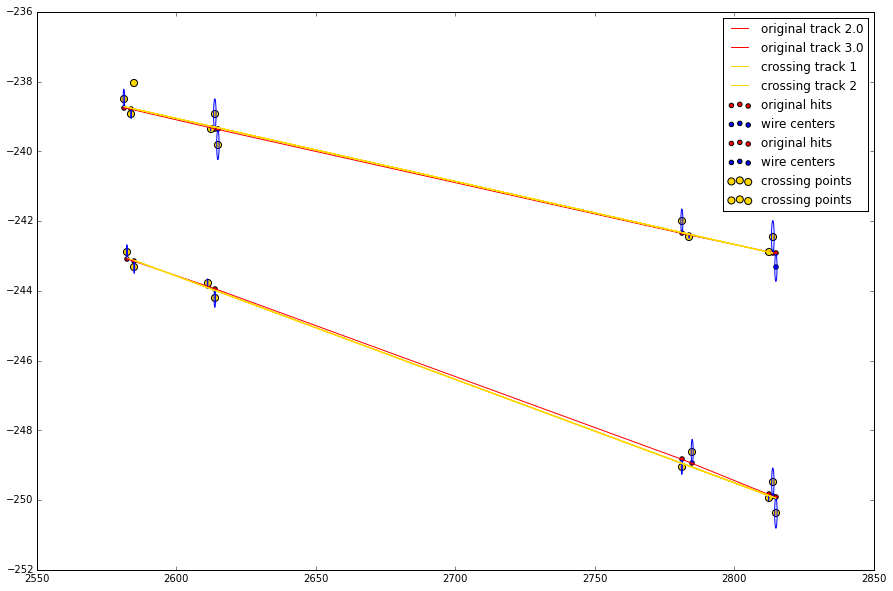

27:


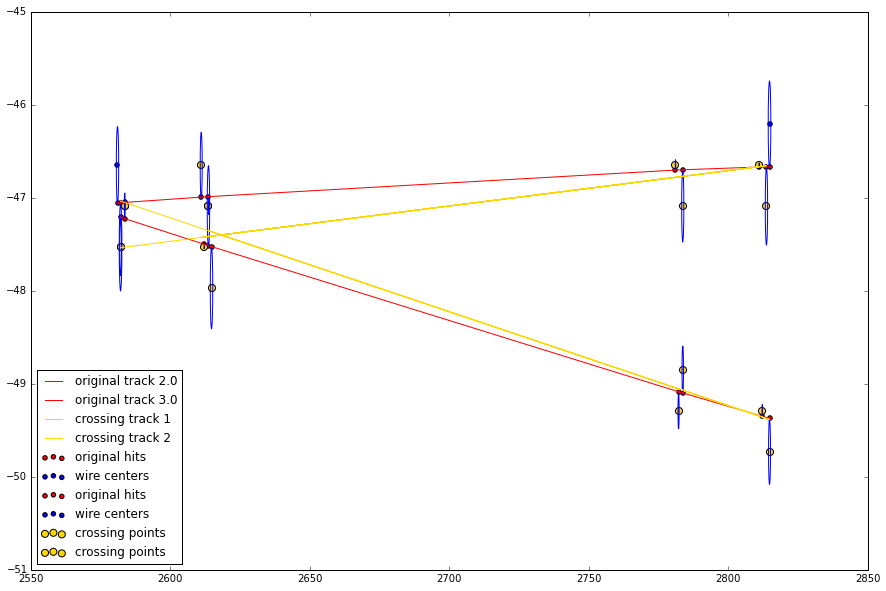

558:


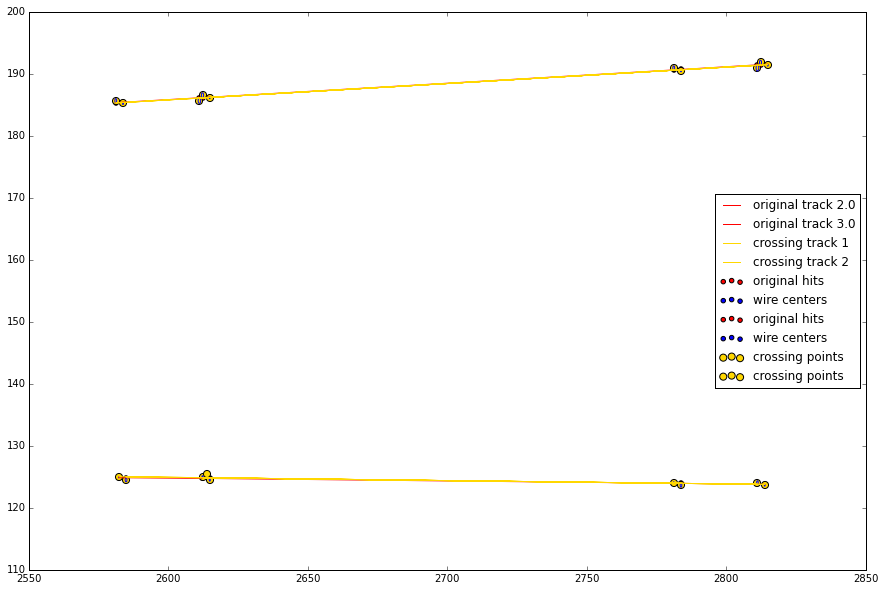

1090:


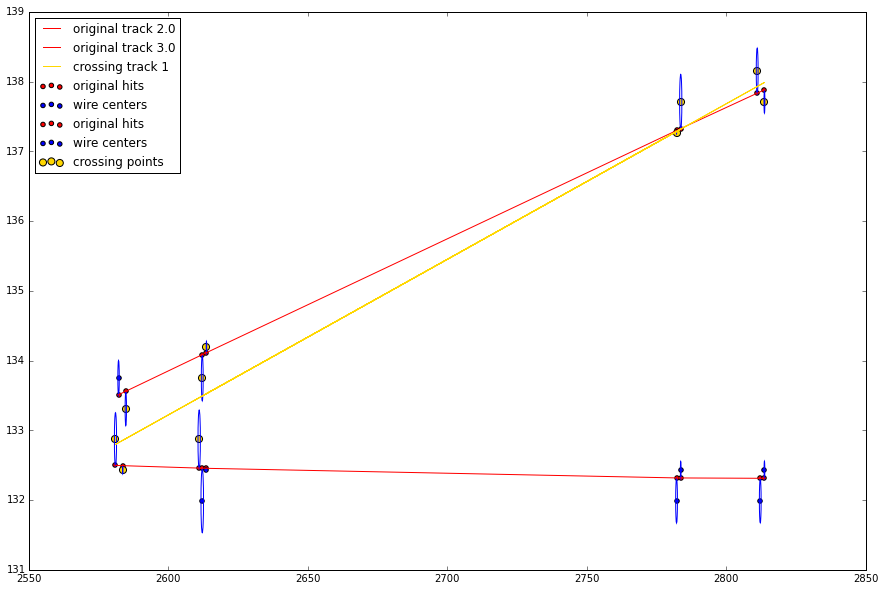

84:


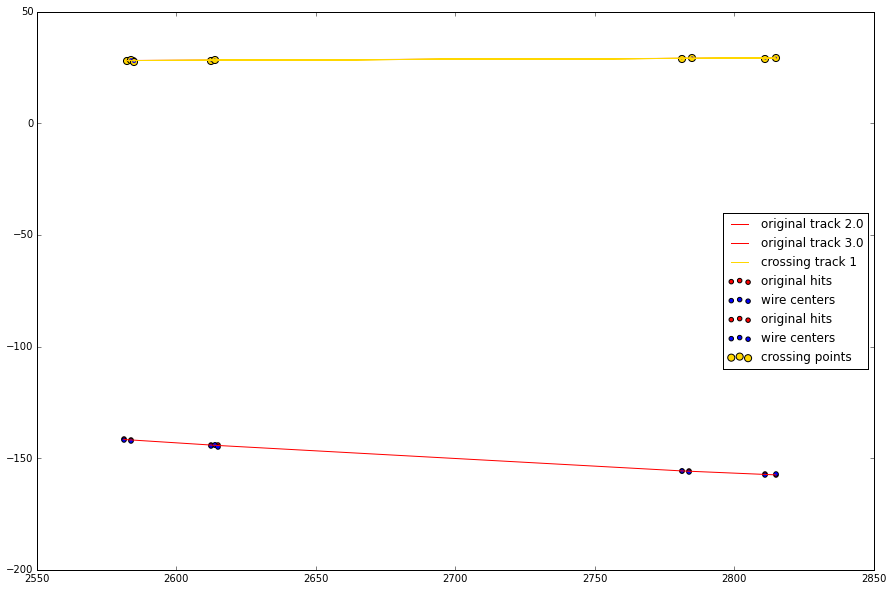

606:


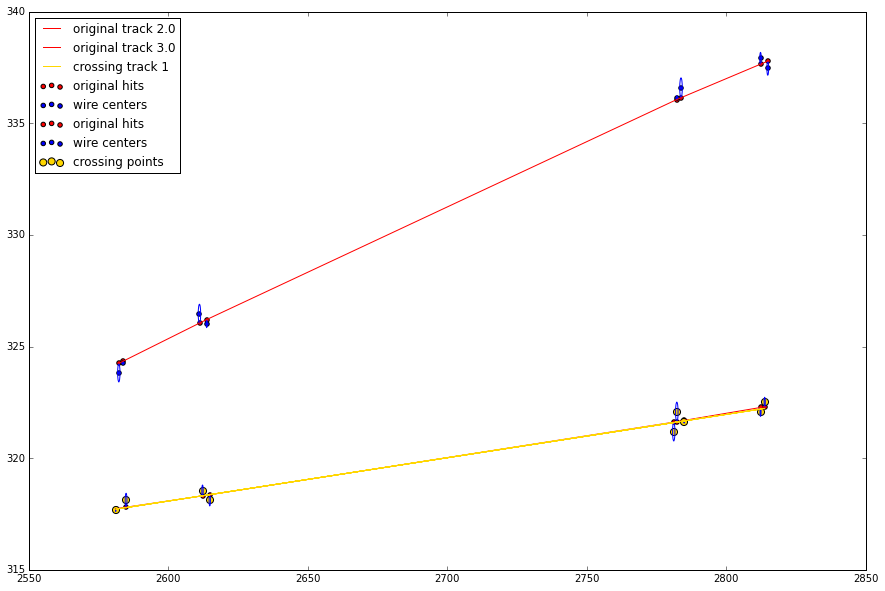

1722:


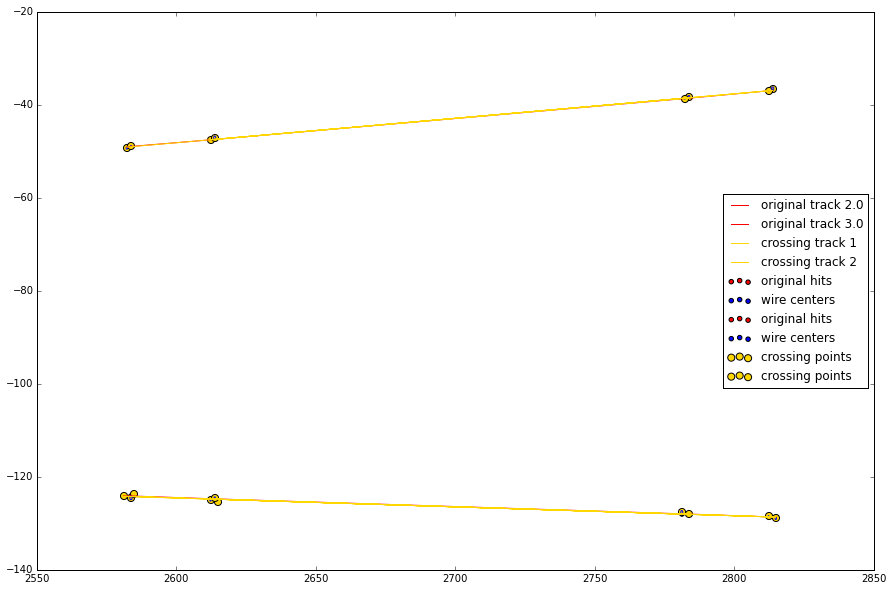

1756:


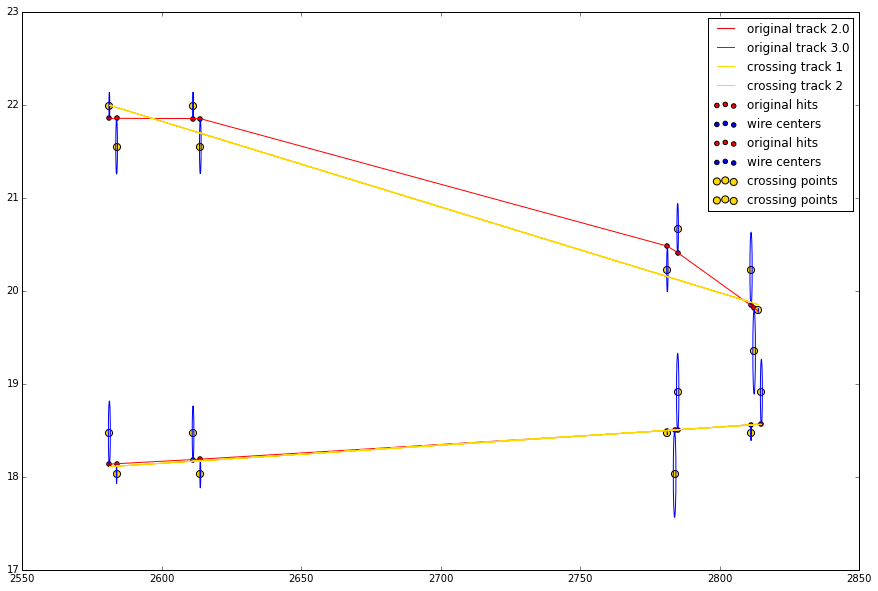

1762:


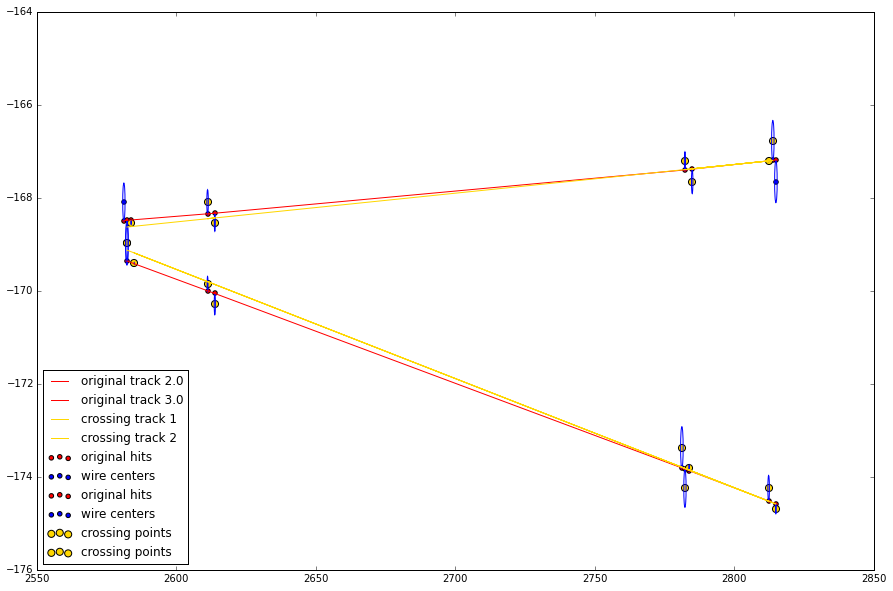

2277:


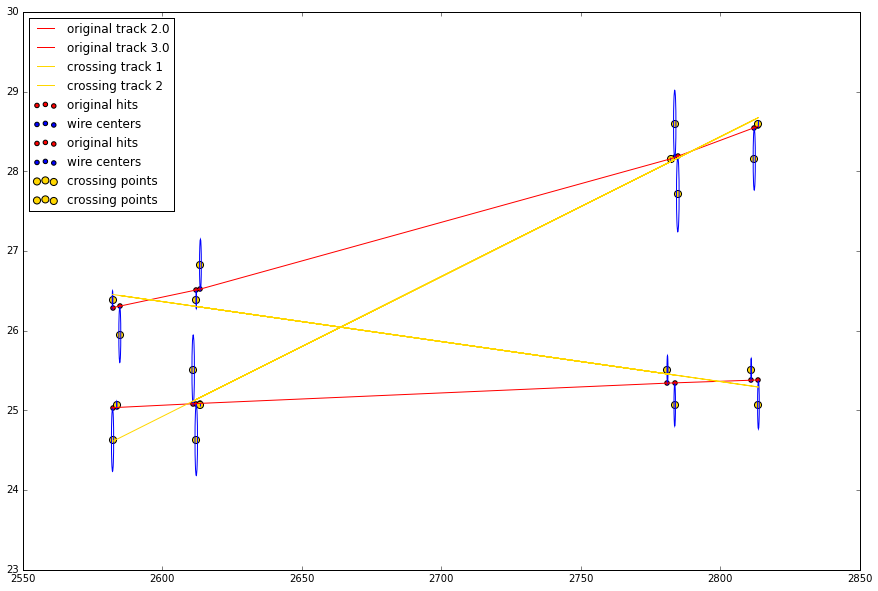

1848:


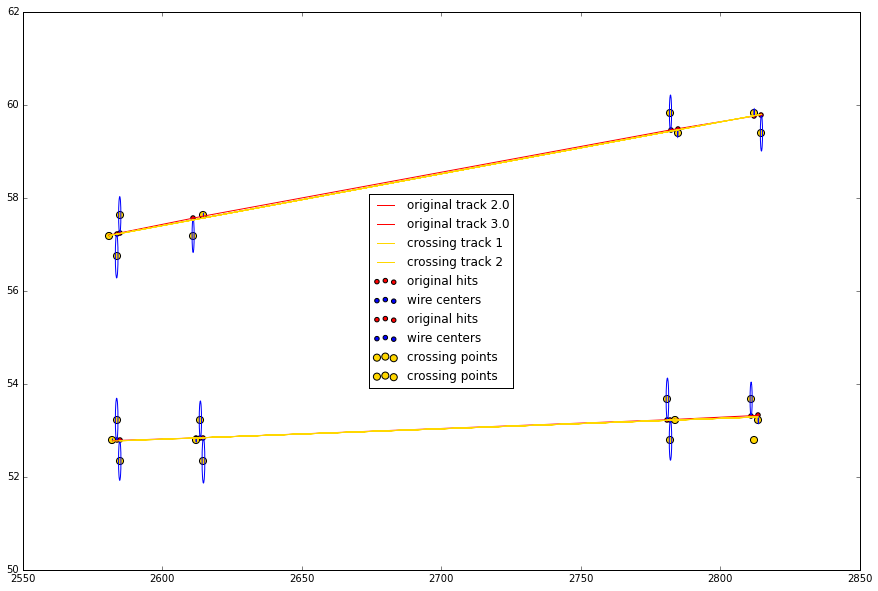

381:


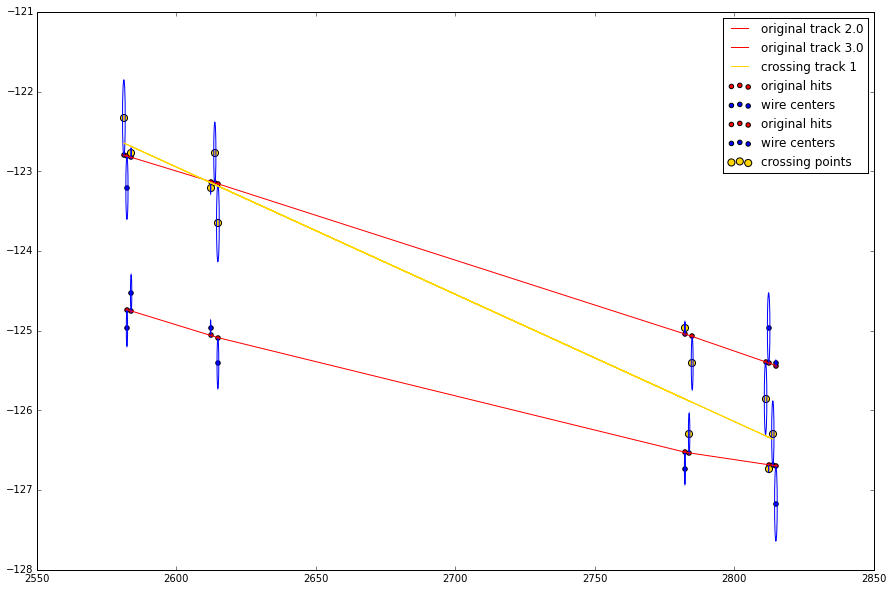

970:


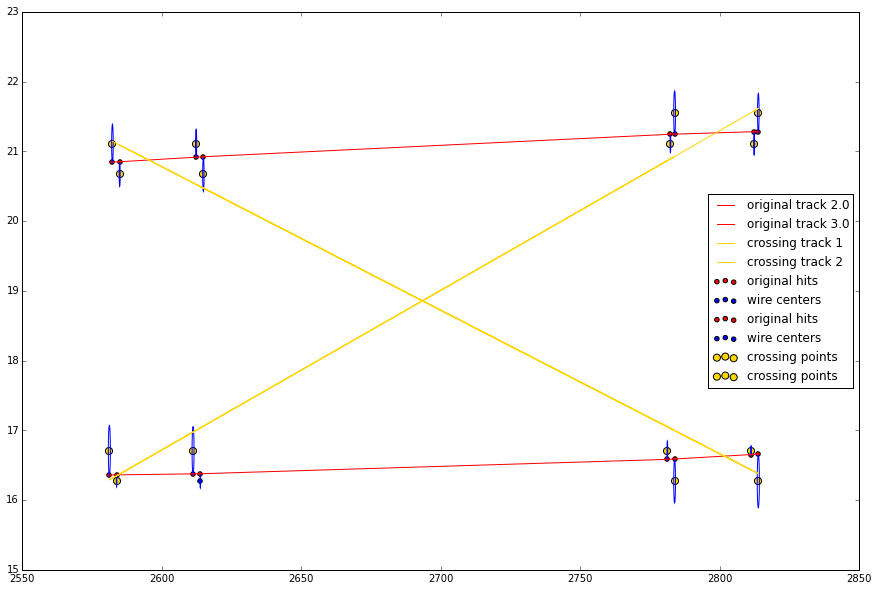

2040:


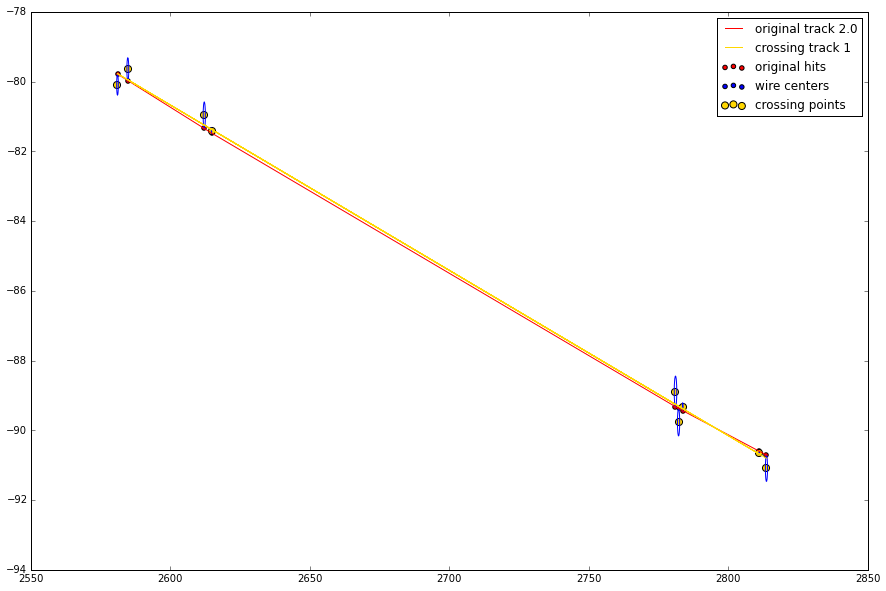

2029:


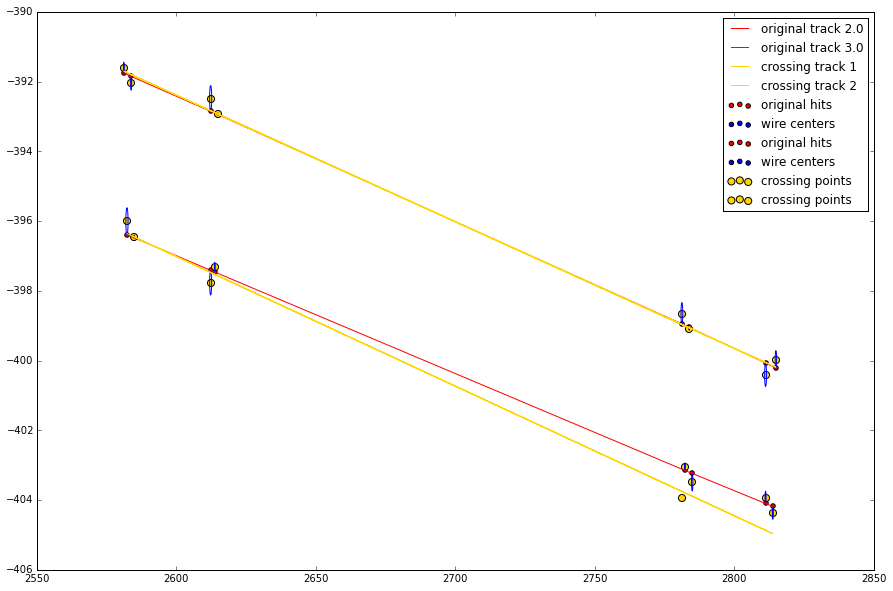

1533:


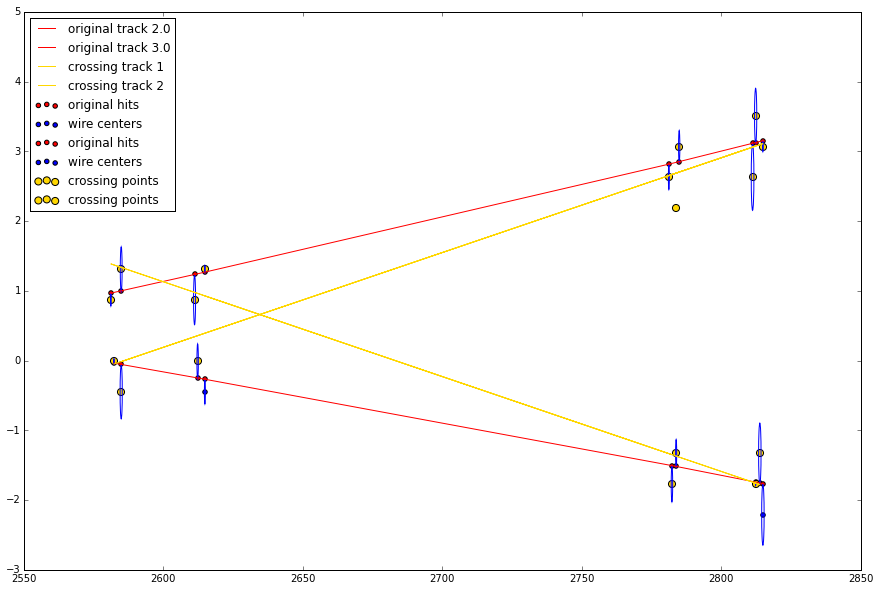

In [23]:
picture(bad_withoutClf, 0)

# With classifier, lin regr

In [12]:
bad_withClf

[1655,
 1204,
 84,
 1111,
 606,
 957,
 1142,
 122,
 642,
 143,
 1704,
 1722,
 2446,
 1242,
 1243,
 1756,
 221,
 806,
 1329,
 341,
 876,
 885,
 897,
 2439,
 2203,
 445,
 2295,
 2040,
 978,
 2029,
 1533]

In [13]:
len(bad_withClf)

31

1655:


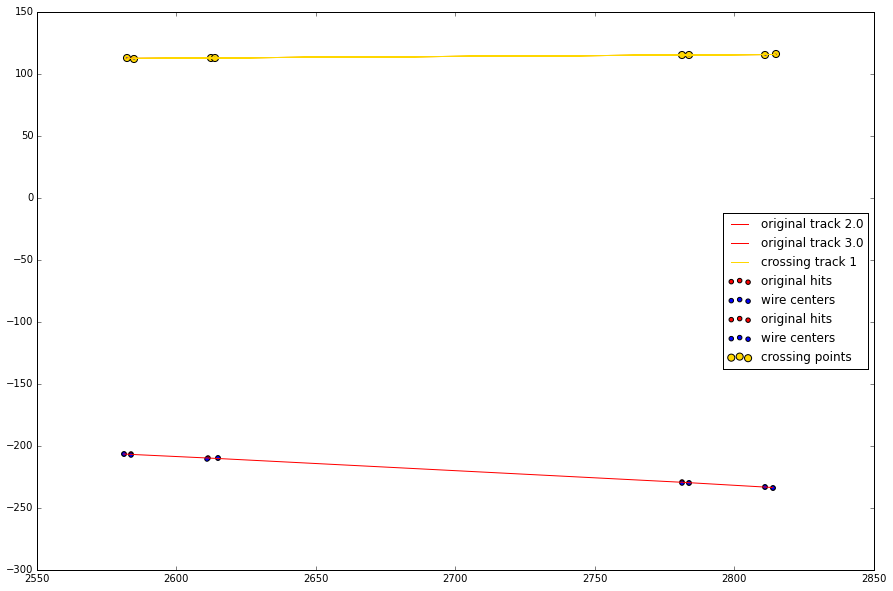

1204:


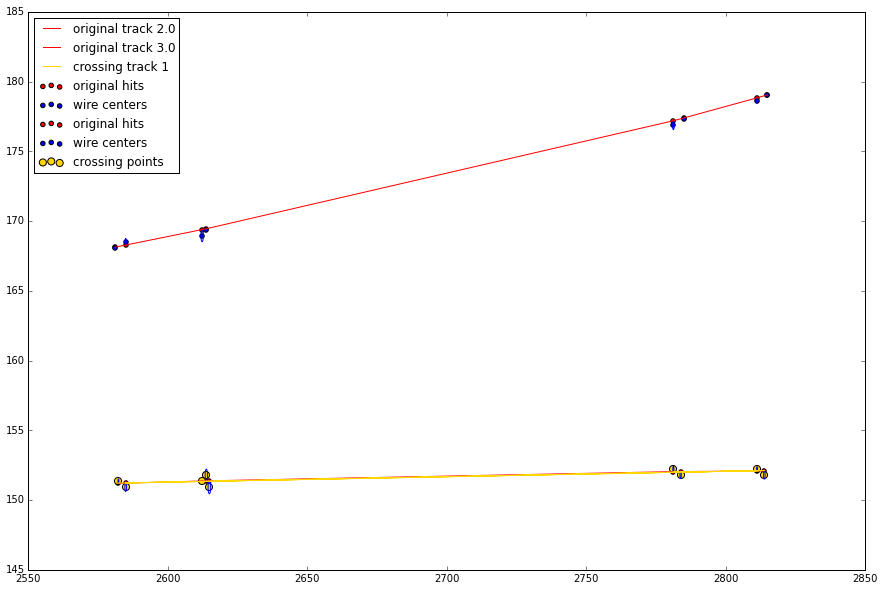

84:


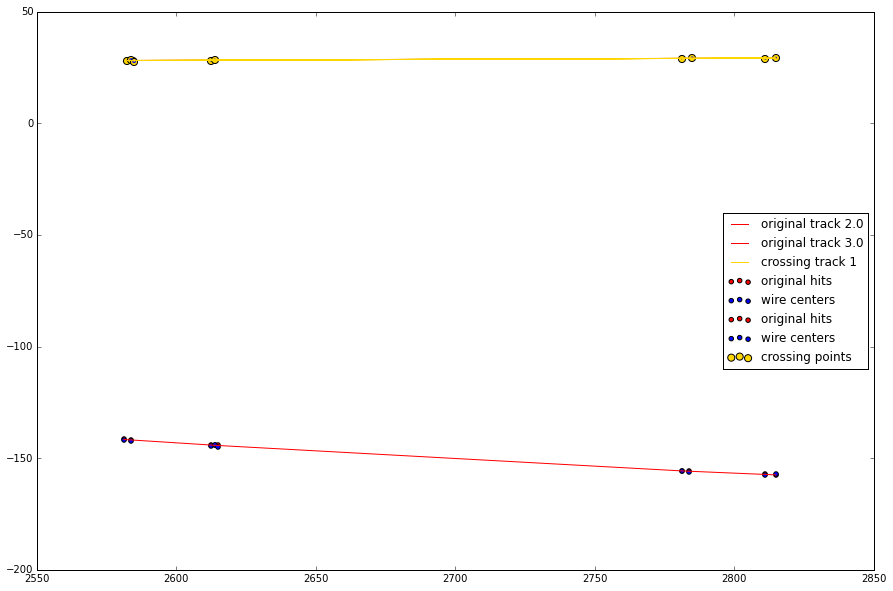

1111:


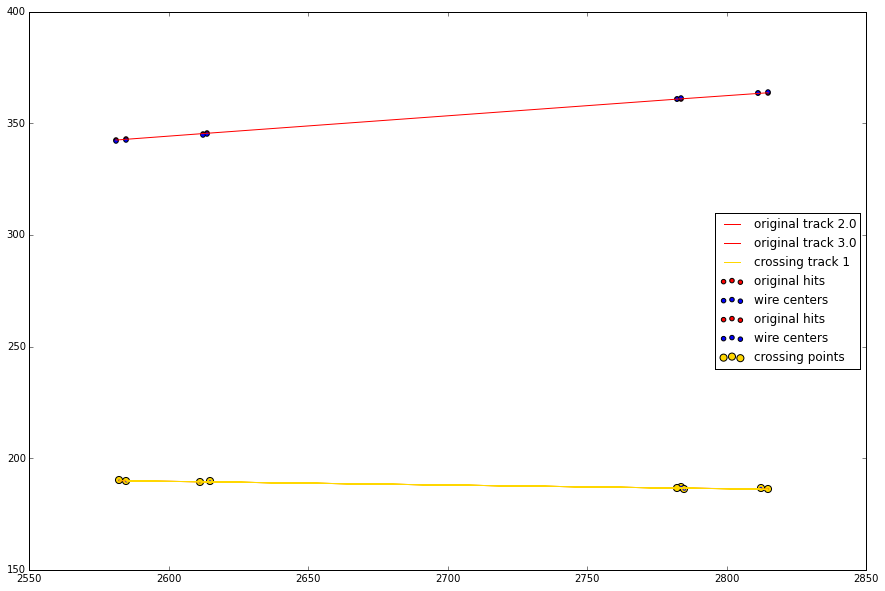

606:


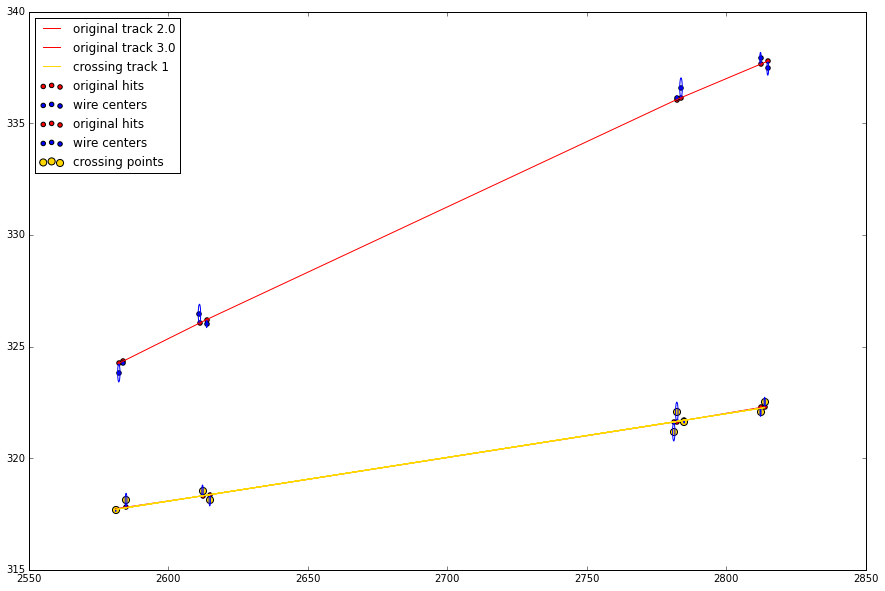

957:


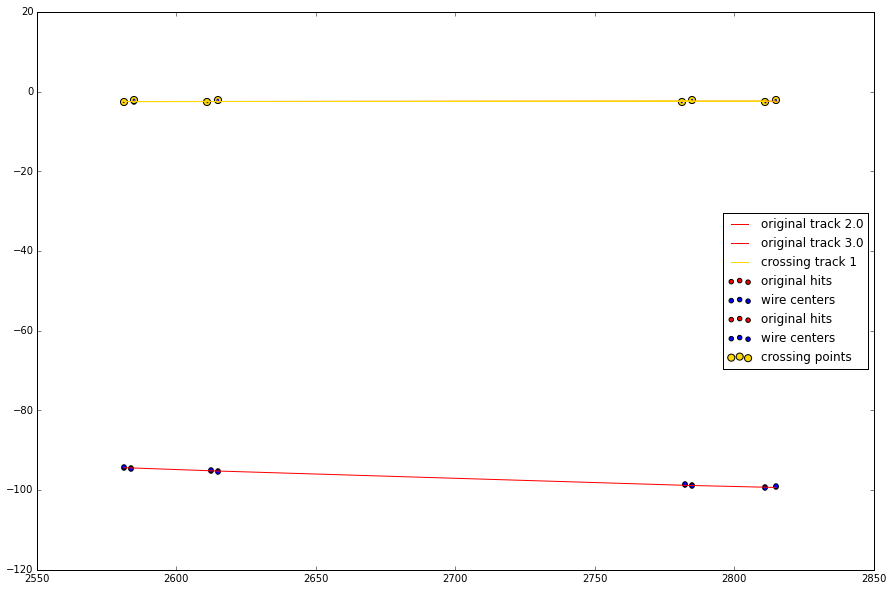

1142:


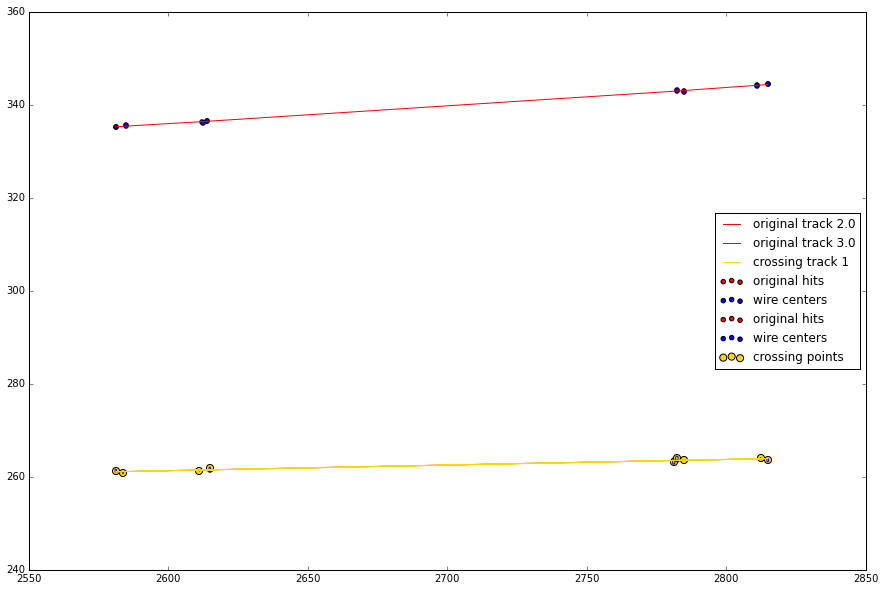

122:


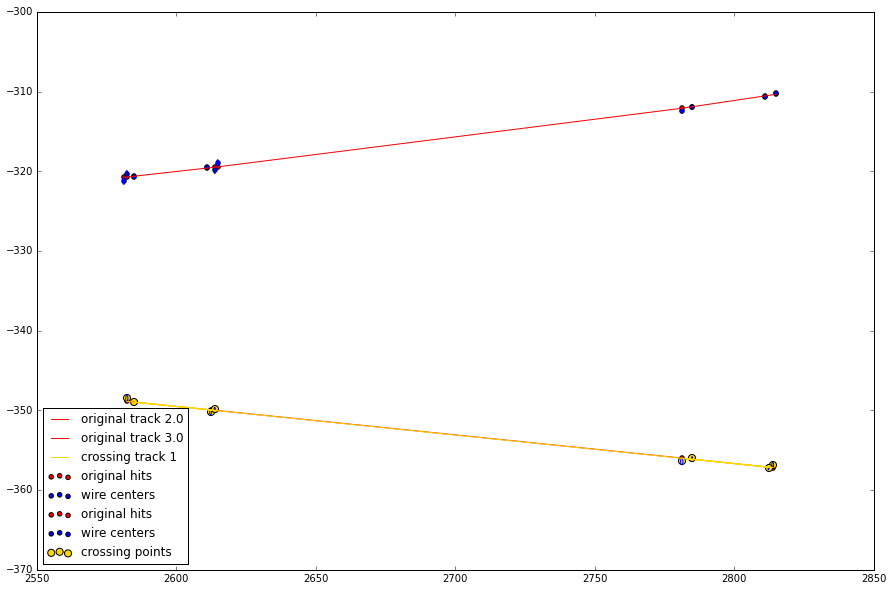

642:


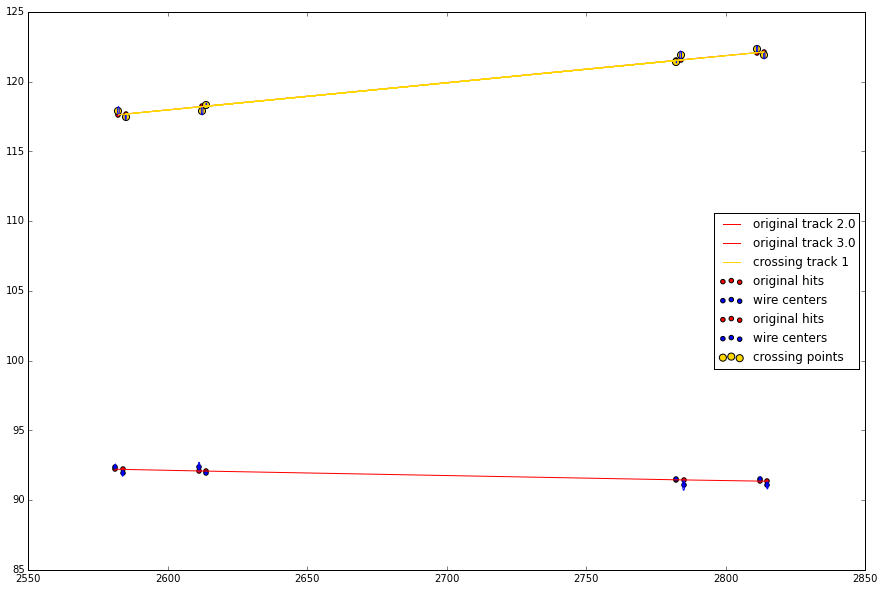

143:


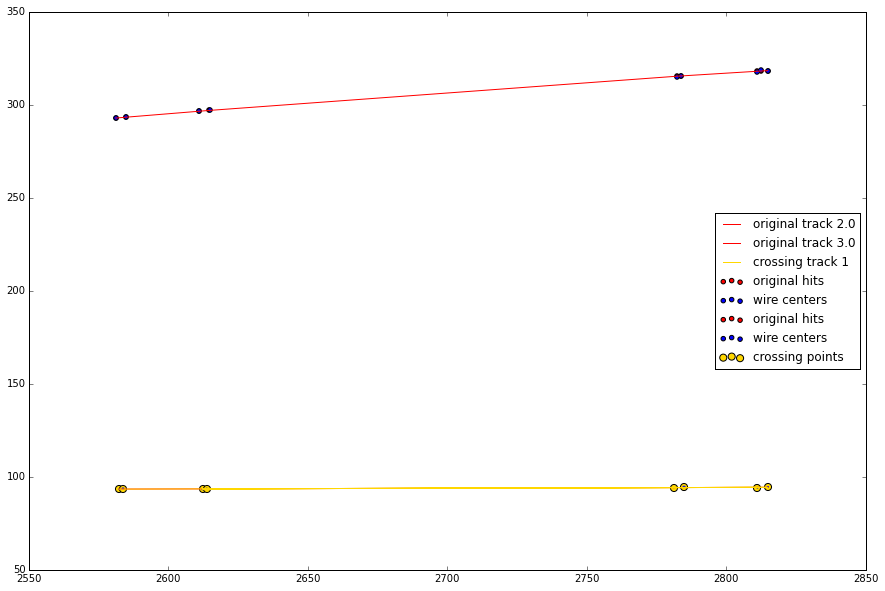

1704:


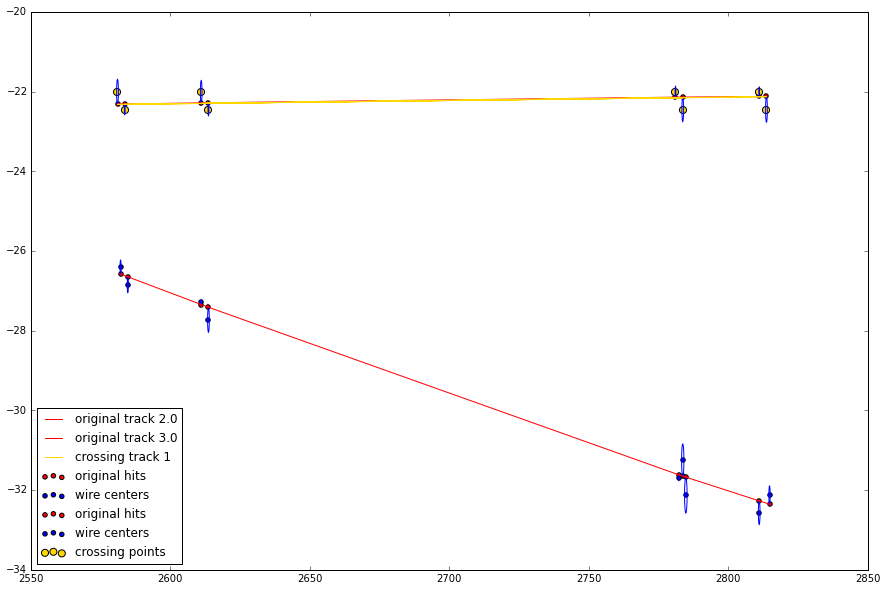

1722:


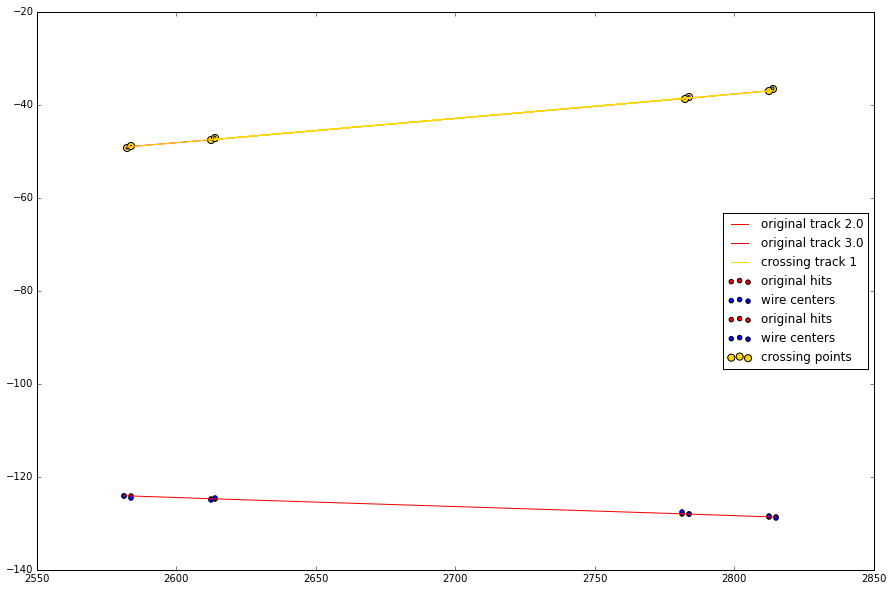

2446:


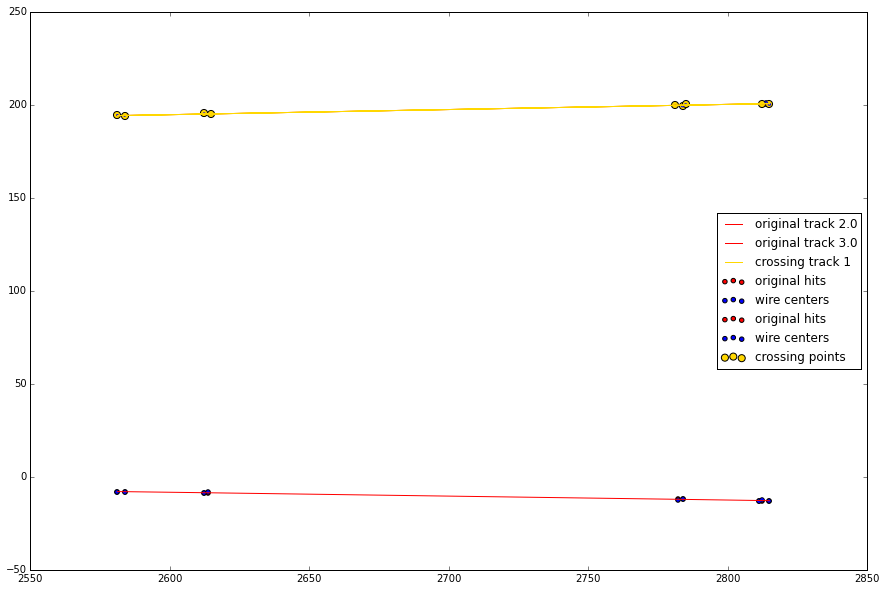

1242:


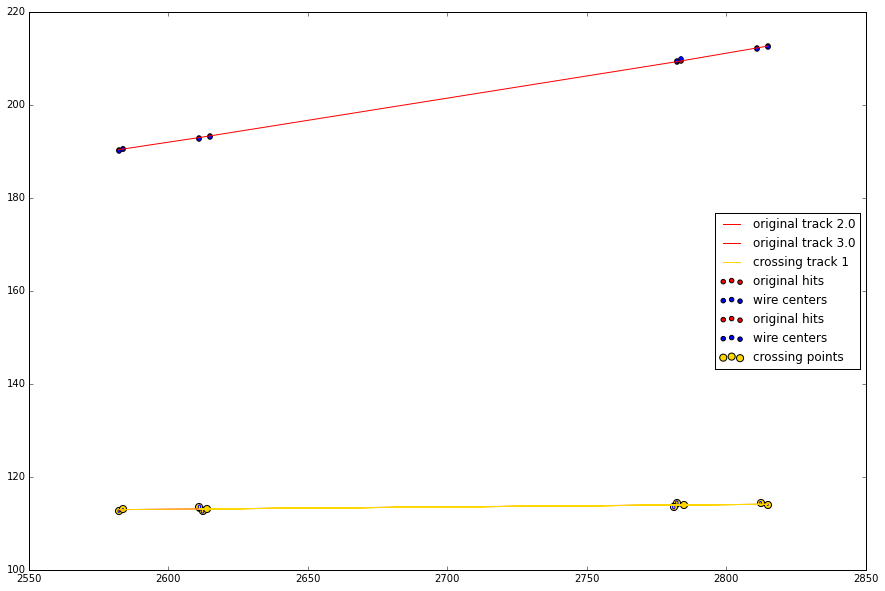

1243:


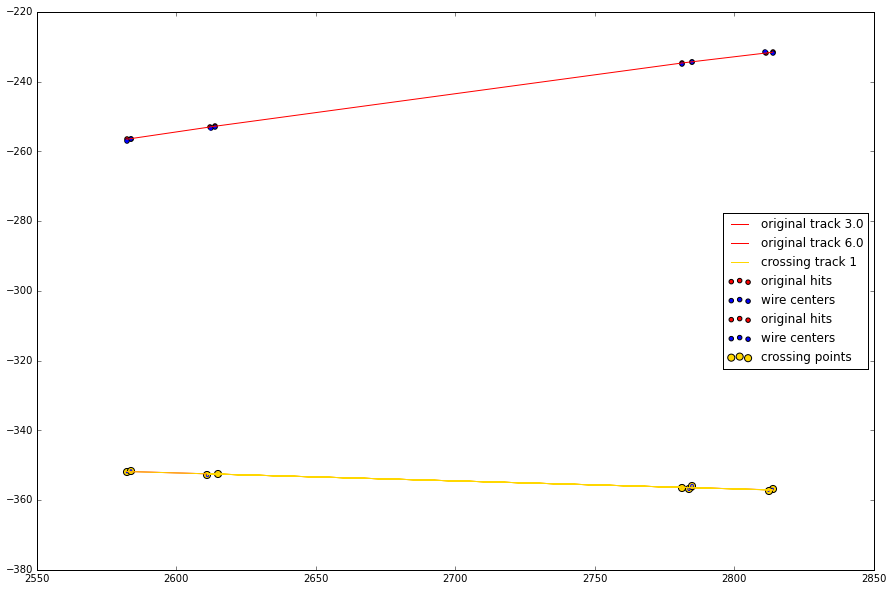

1756:


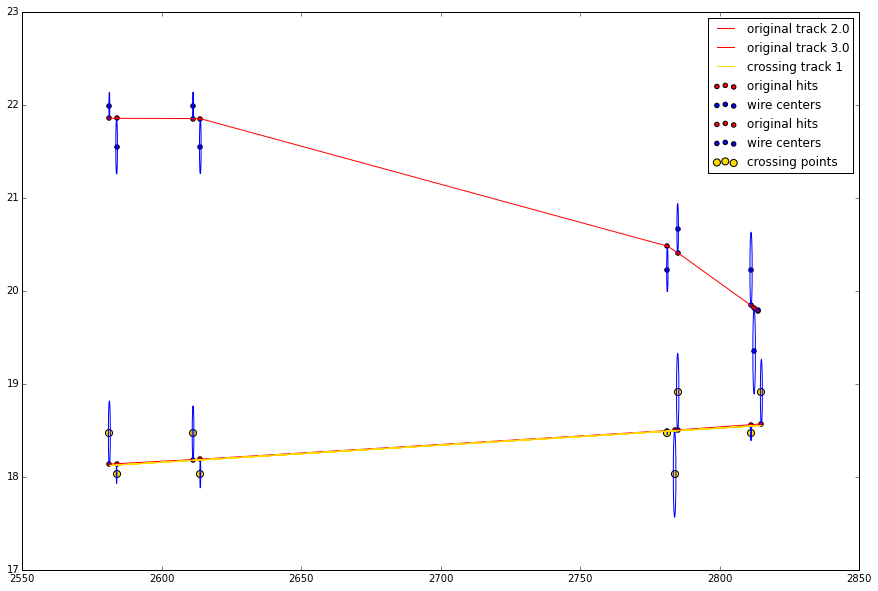

221:


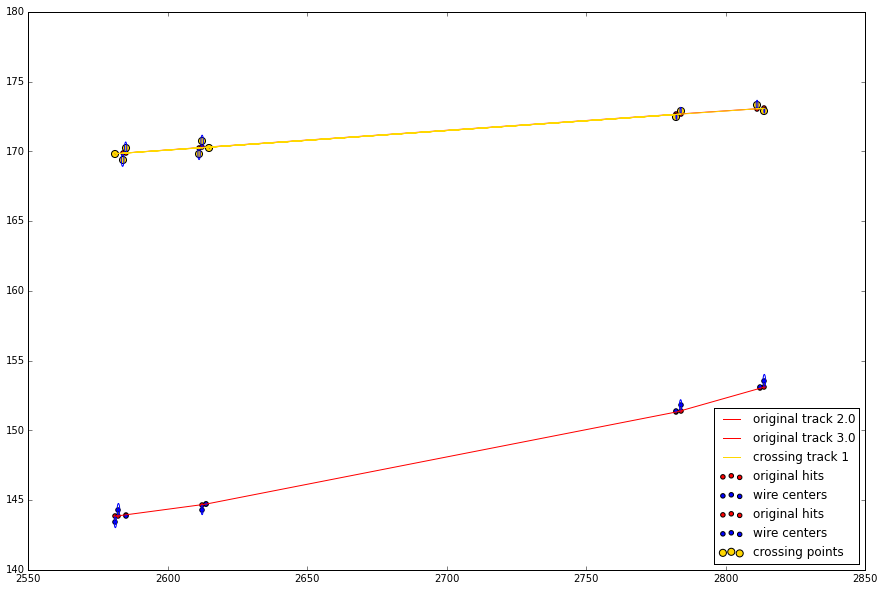

806:


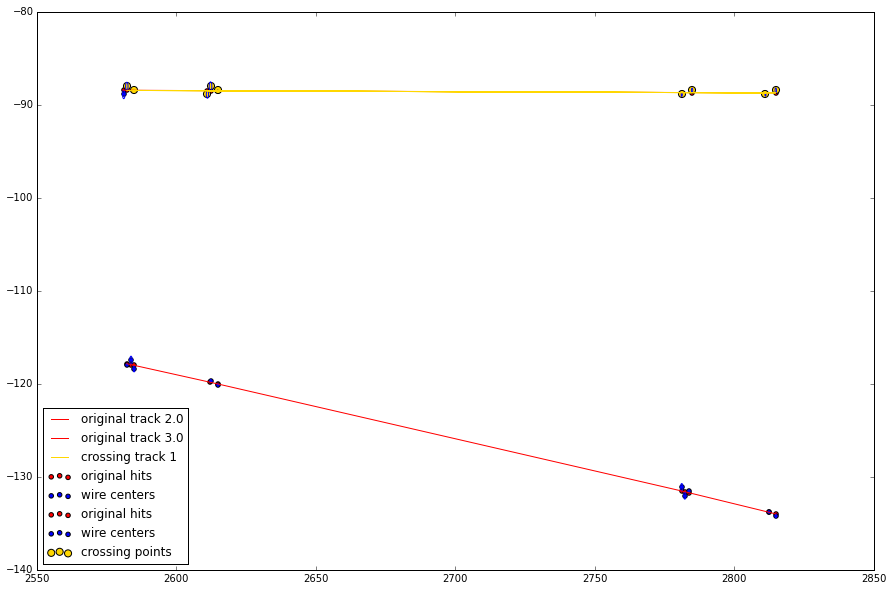

1329:


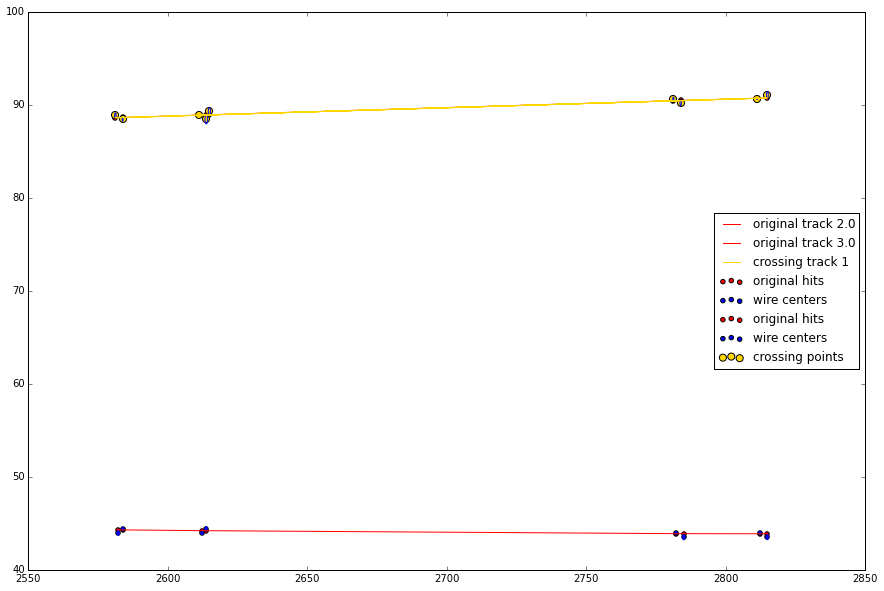

341:


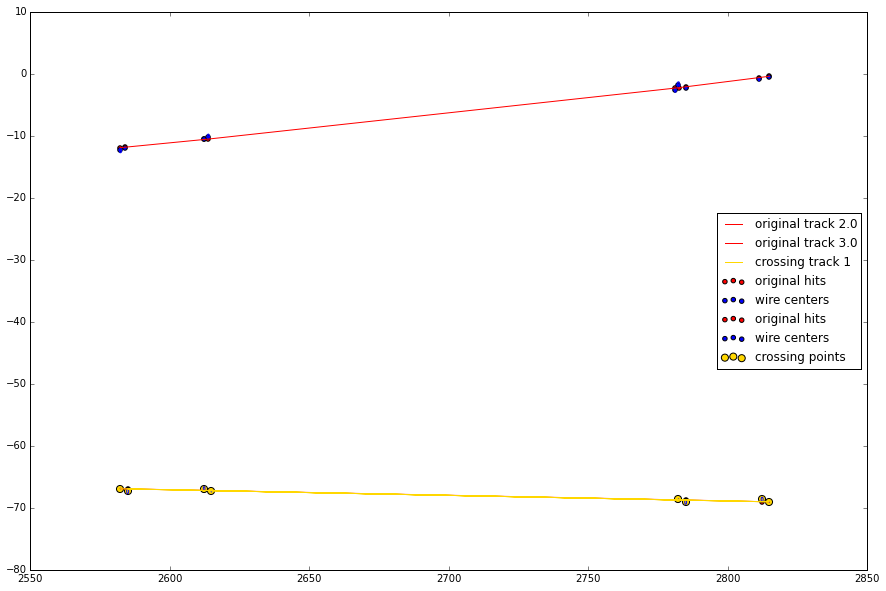

876:


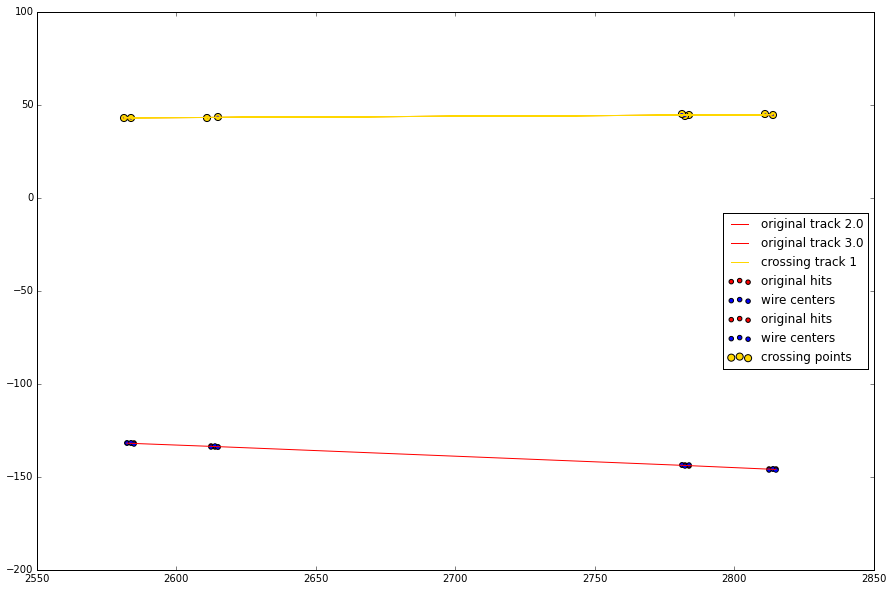

885:


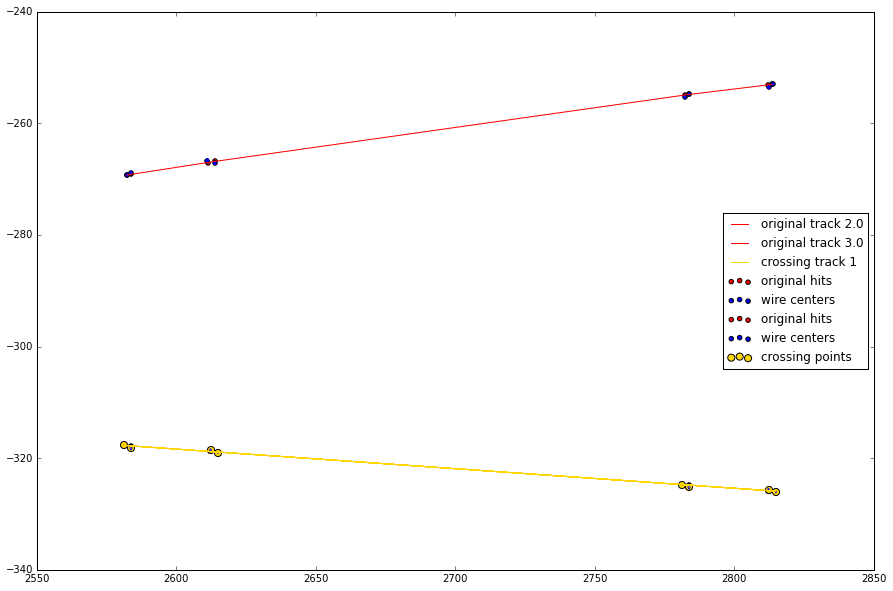

897:


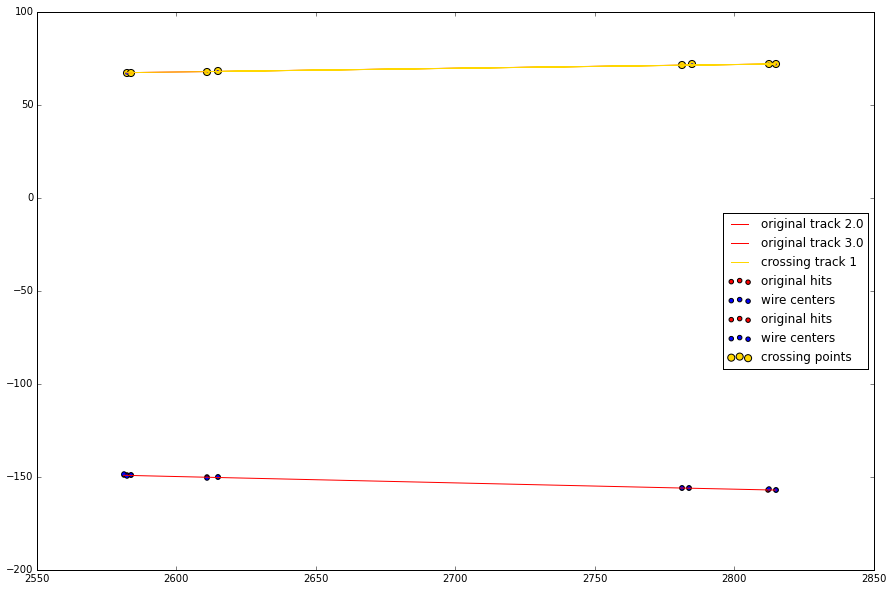

2439:


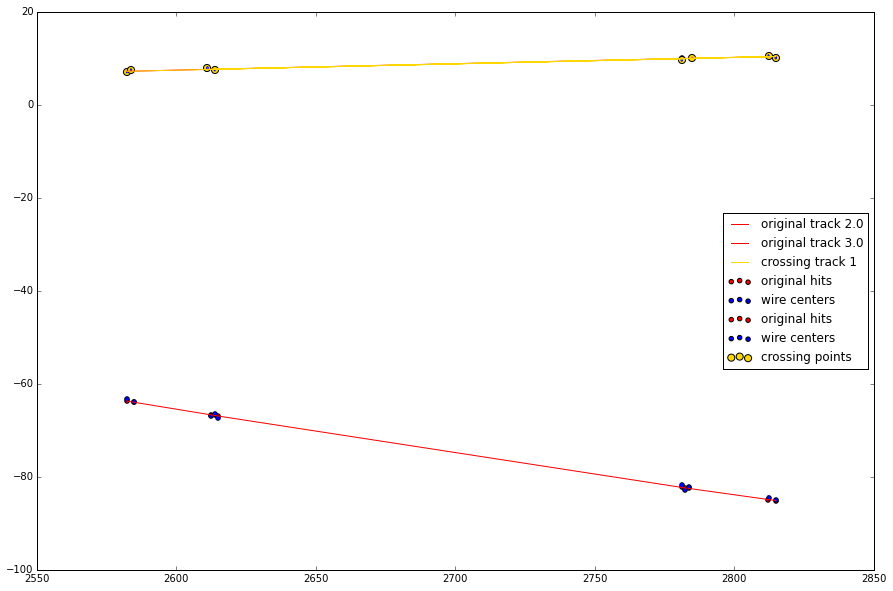

2203:


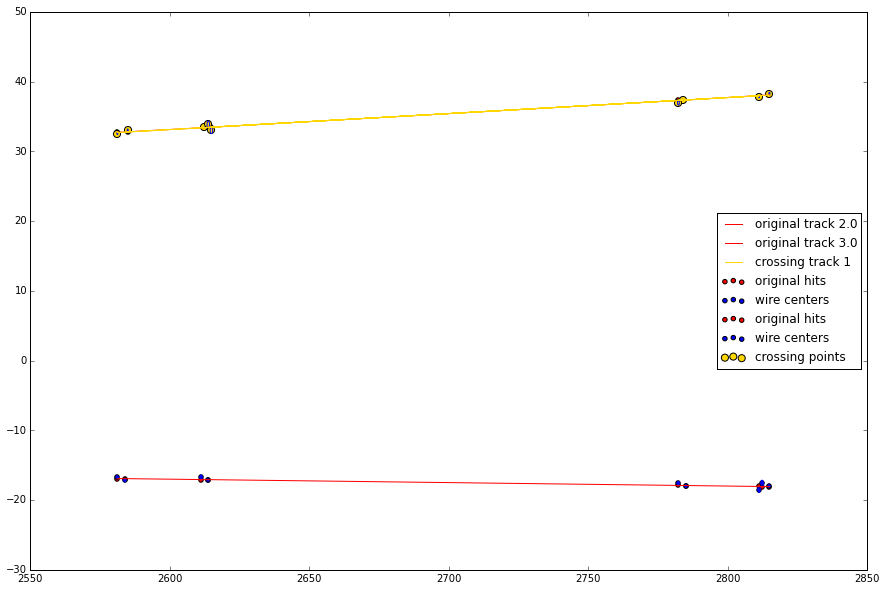

445:


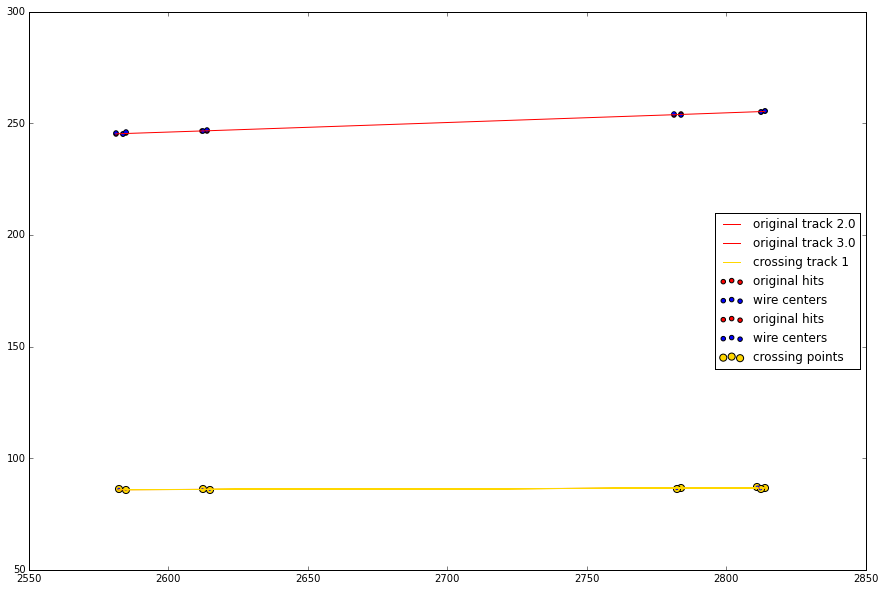

2295:


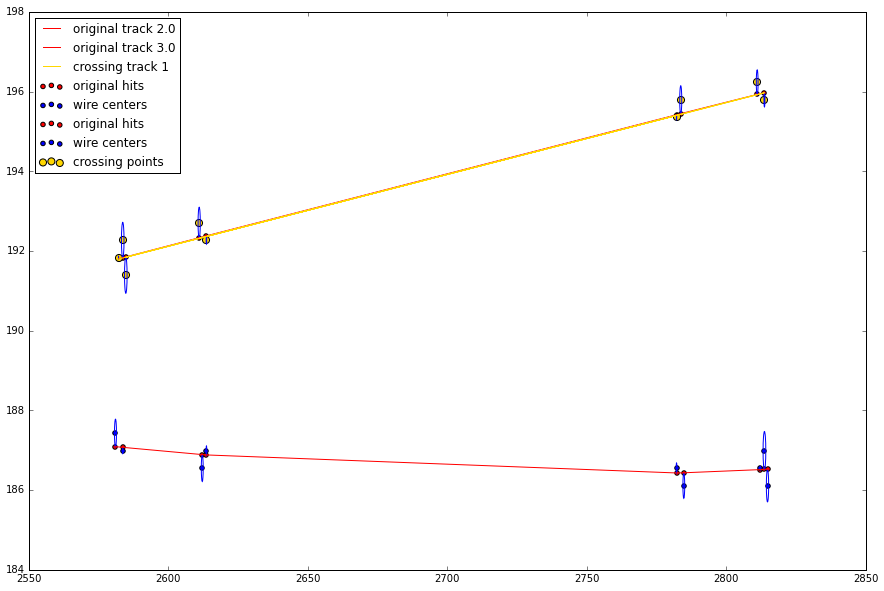

2040:


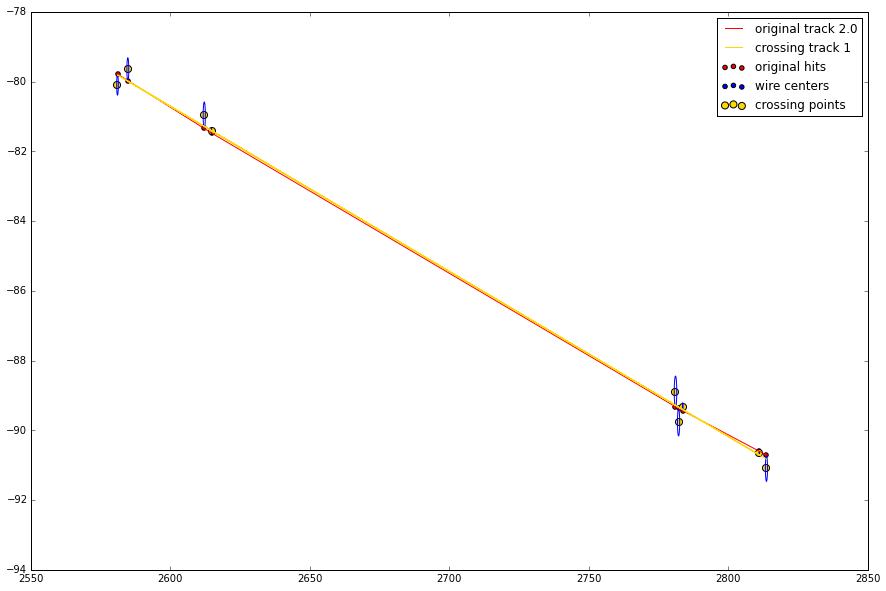

978:


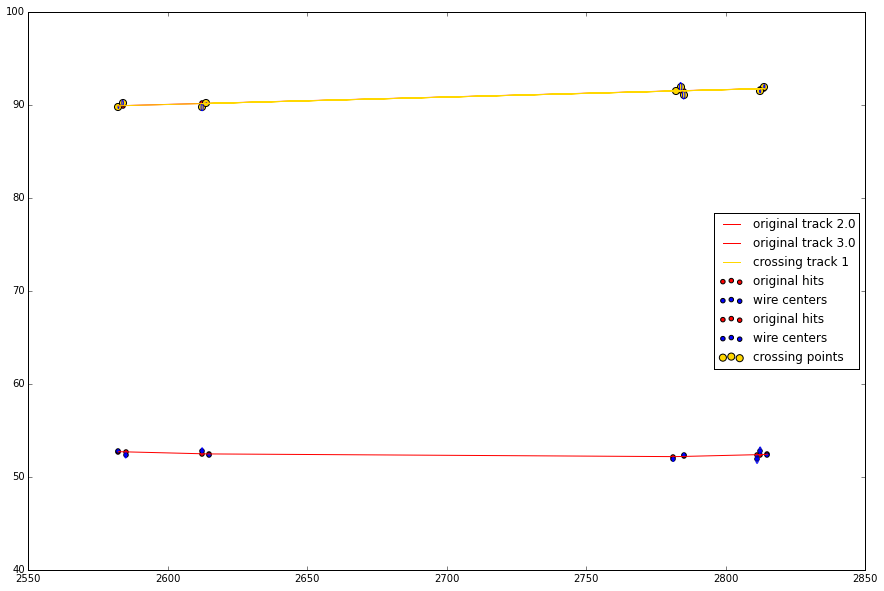

2029:


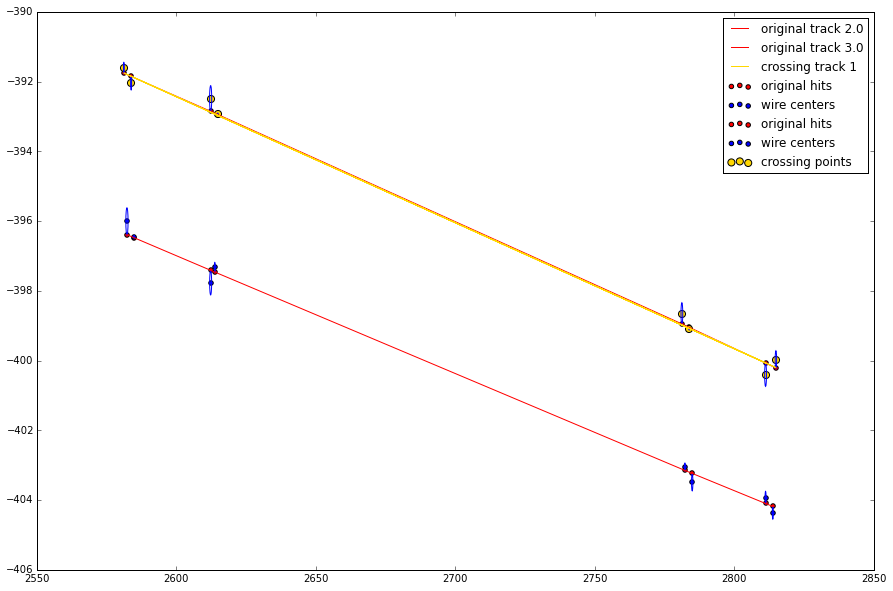

1533:


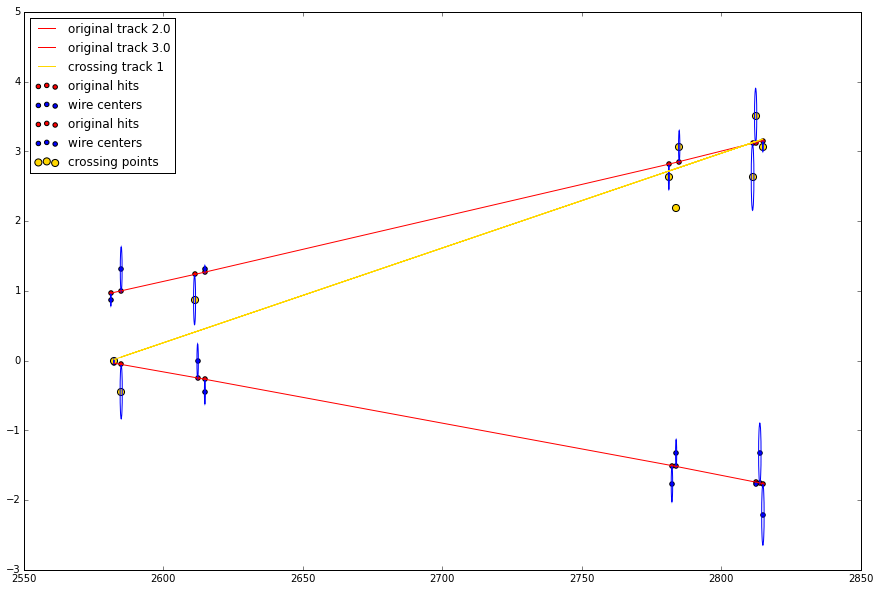

In [14]:
pictureClf(bad_withClf, 0, clf)

# Without classifier, mlr

In [26]:
bad_withoutClf_mlr

[1036,
 27,
 558,
 1090,
 84,
 606,
 1722,
 1756,
 1762,
 2277,
 1848,
 381,
 970,
 2040,
 2029,
 1533]

1036:


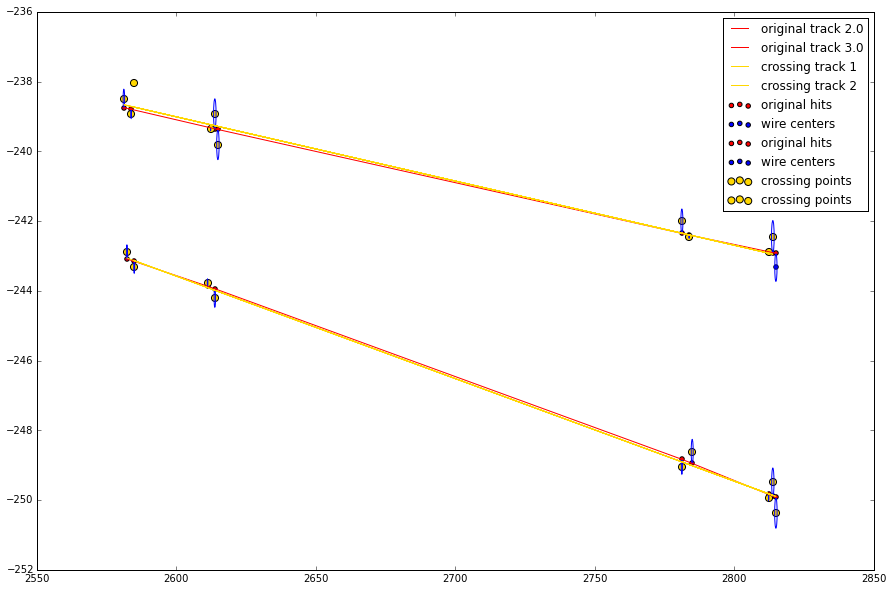

27:


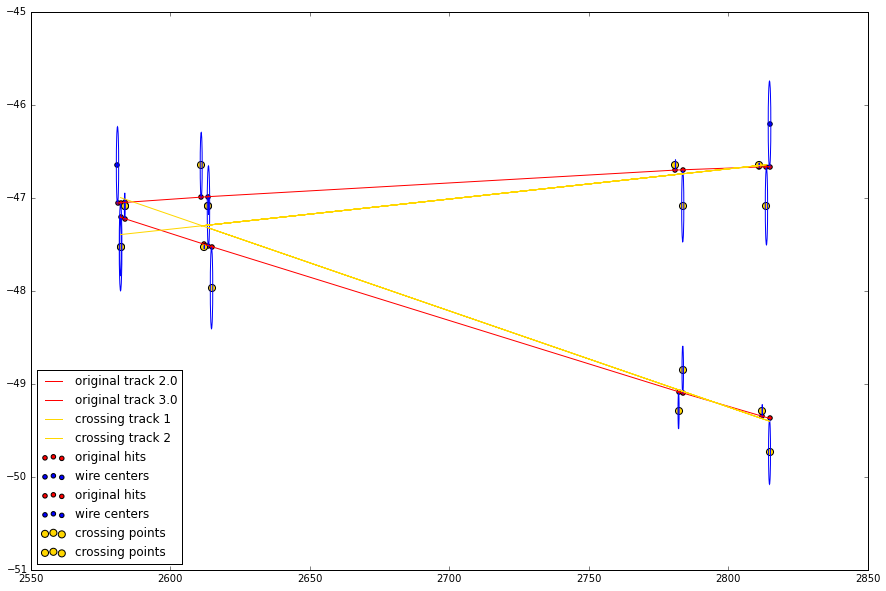

558:


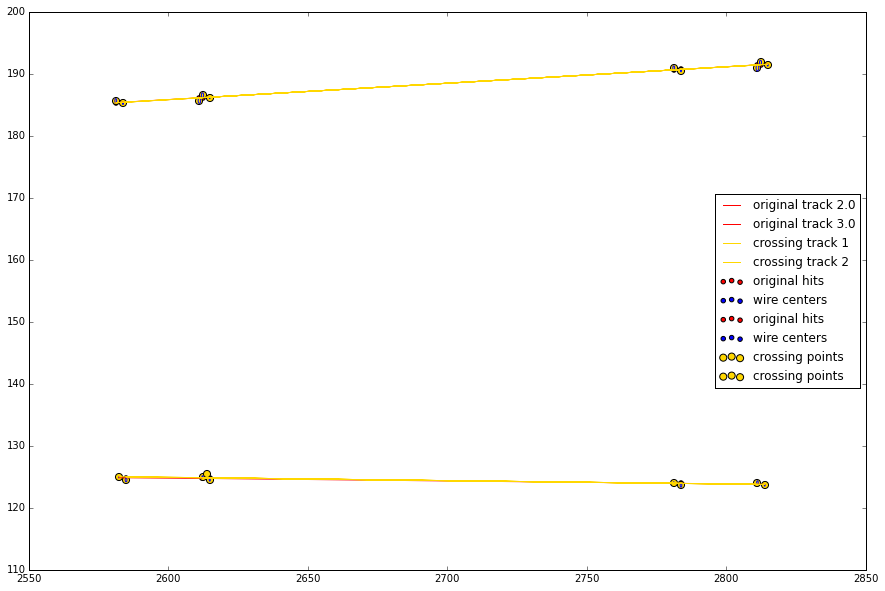

1090:


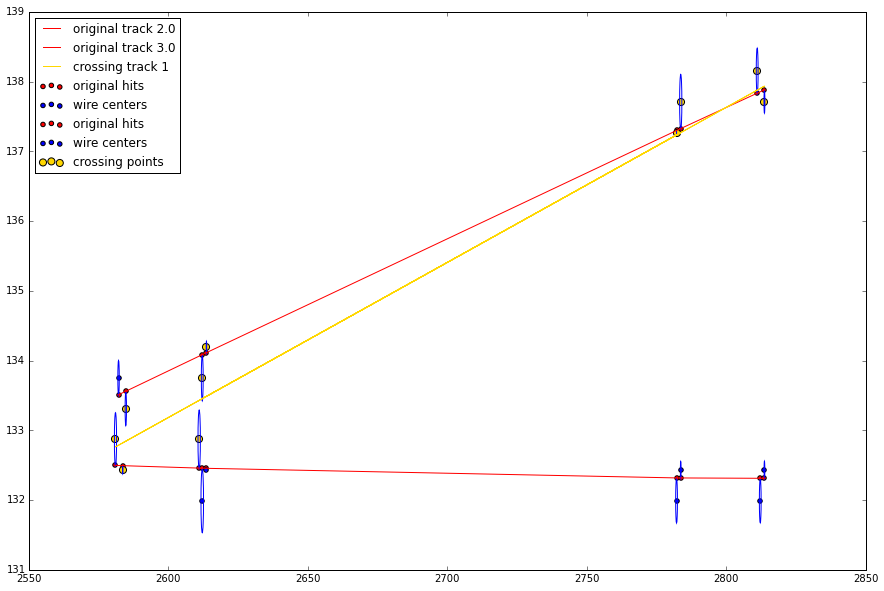

84:


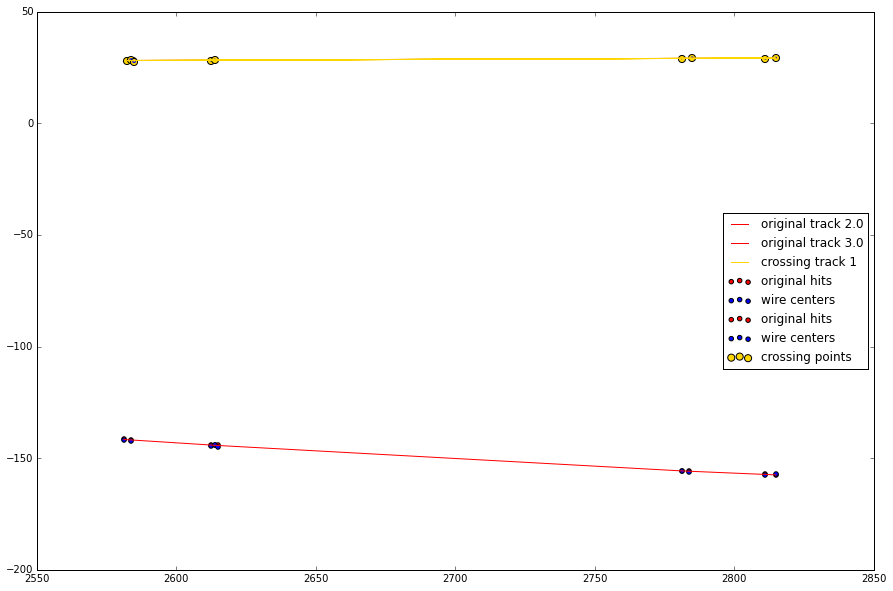

606:


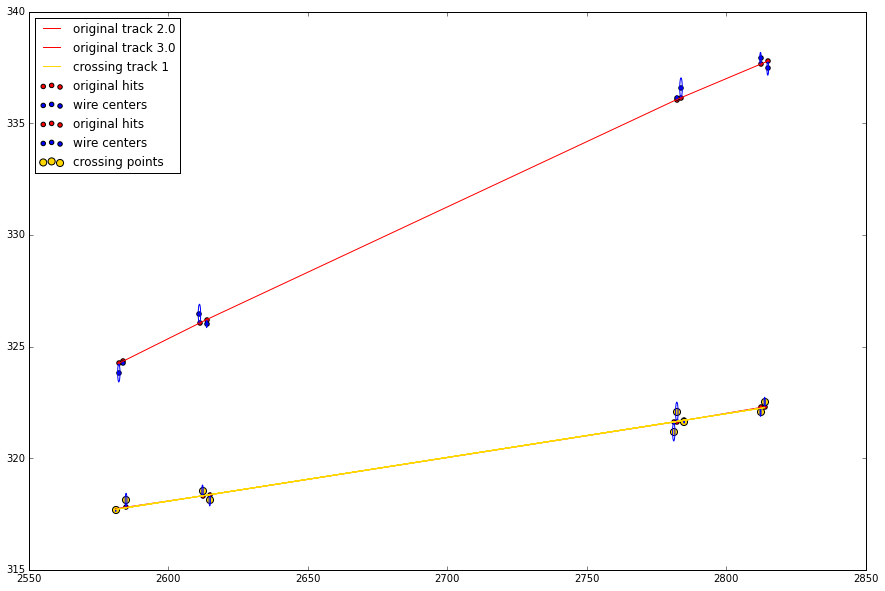

1722:


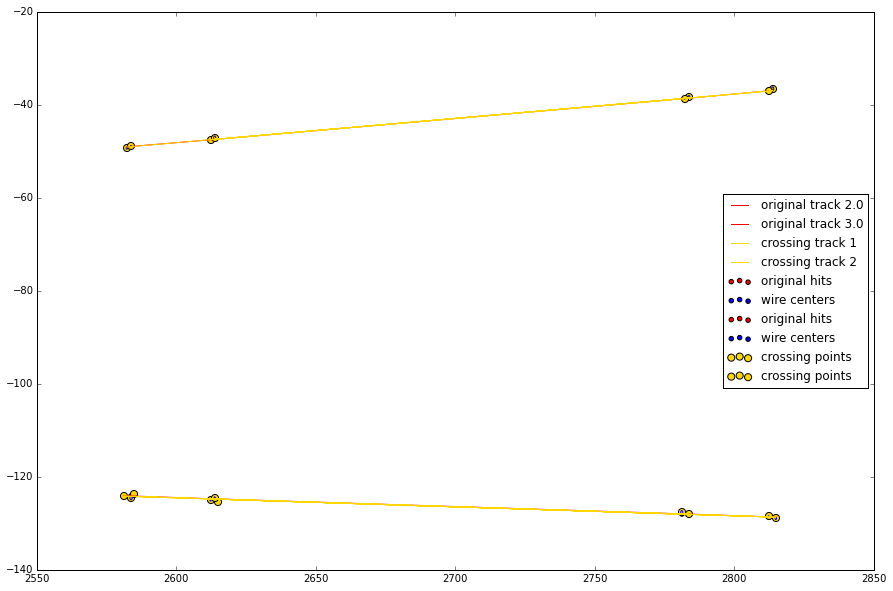

1756:


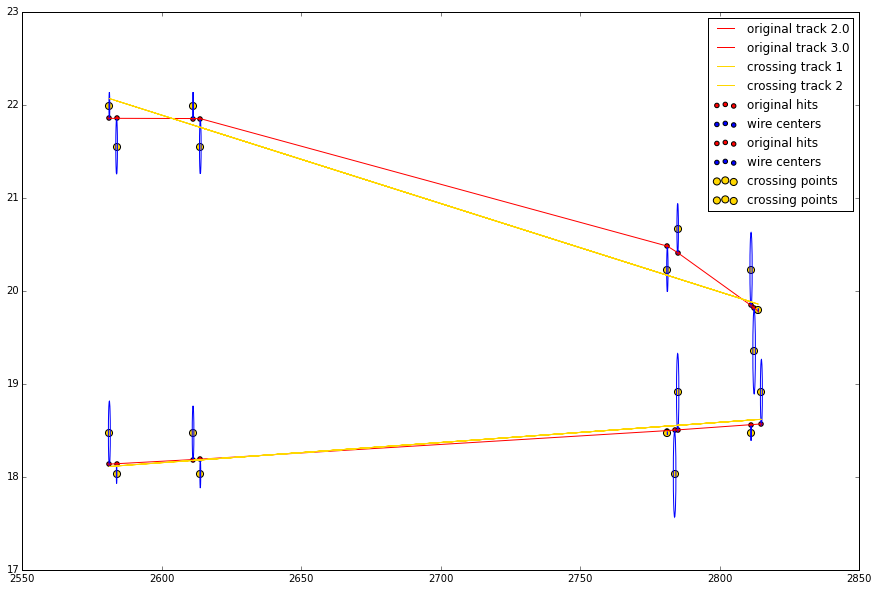

1762:


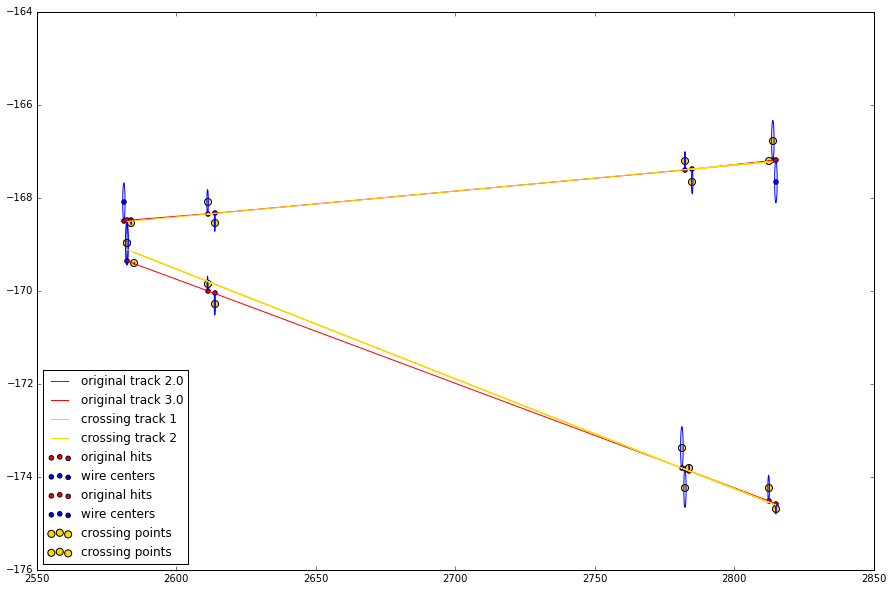

2277:


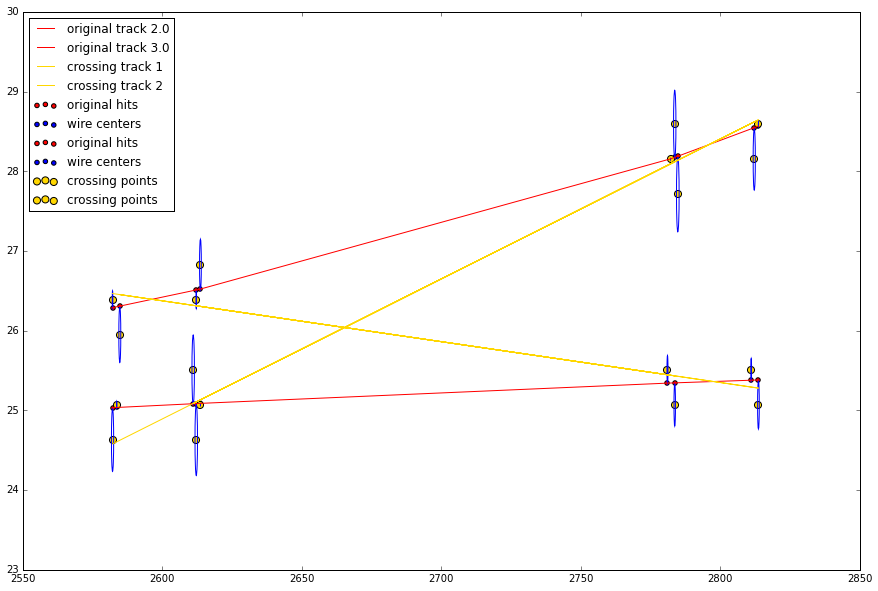

1848:


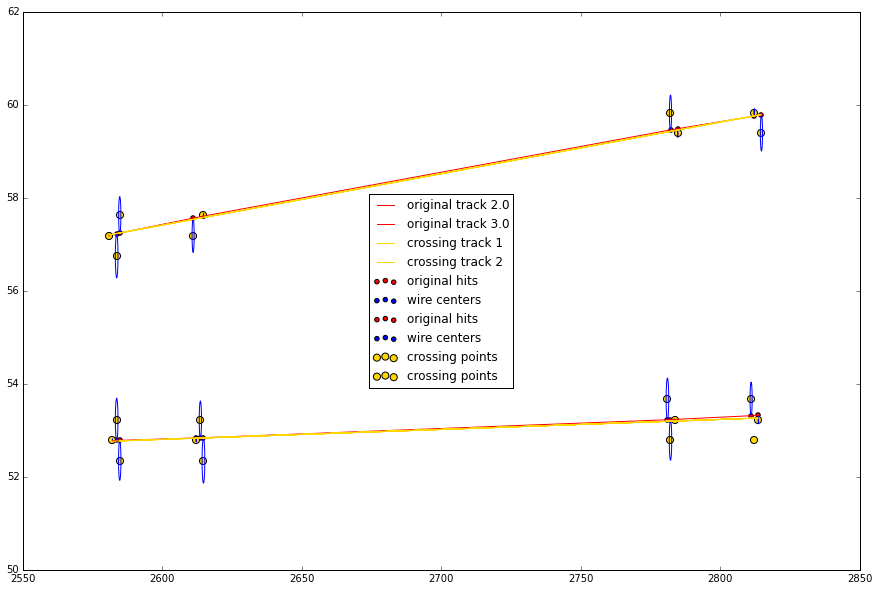

381:


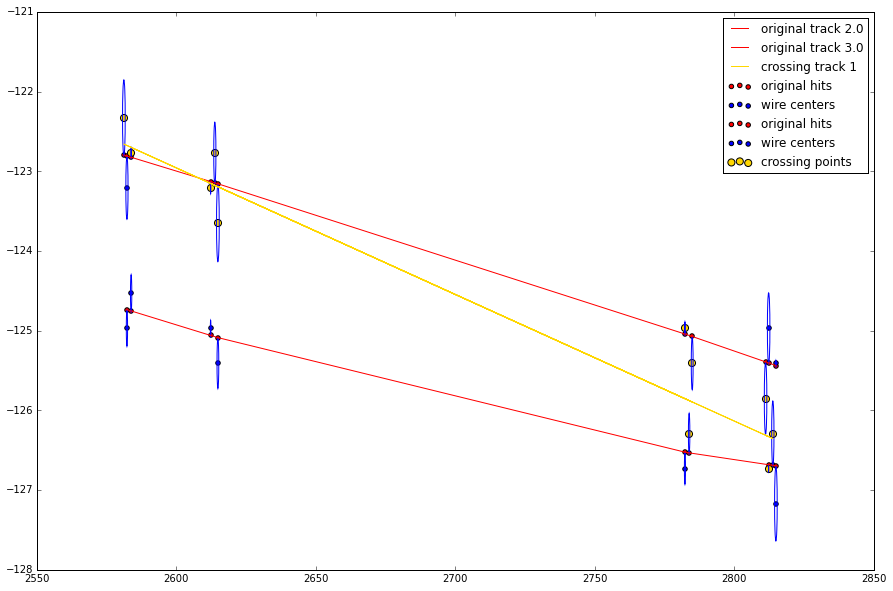

970:


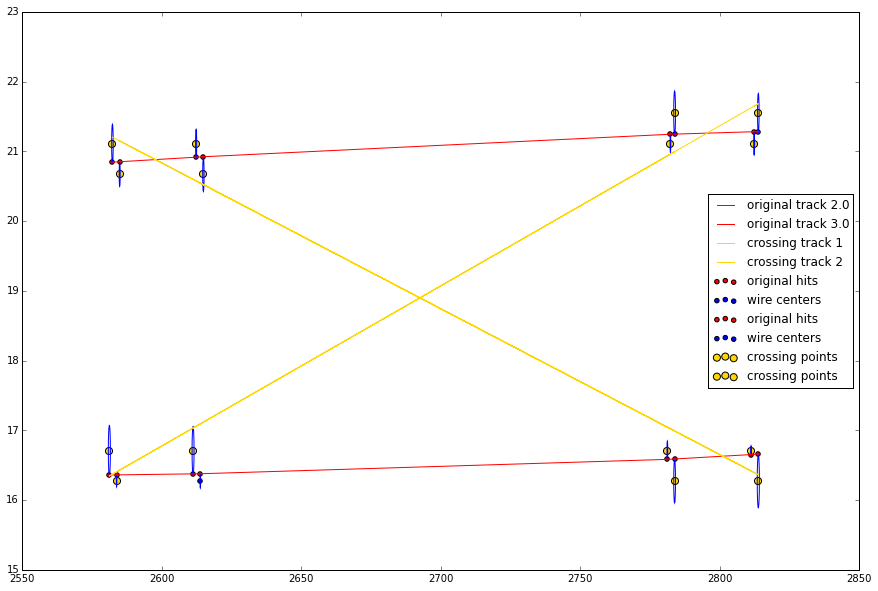

2040:


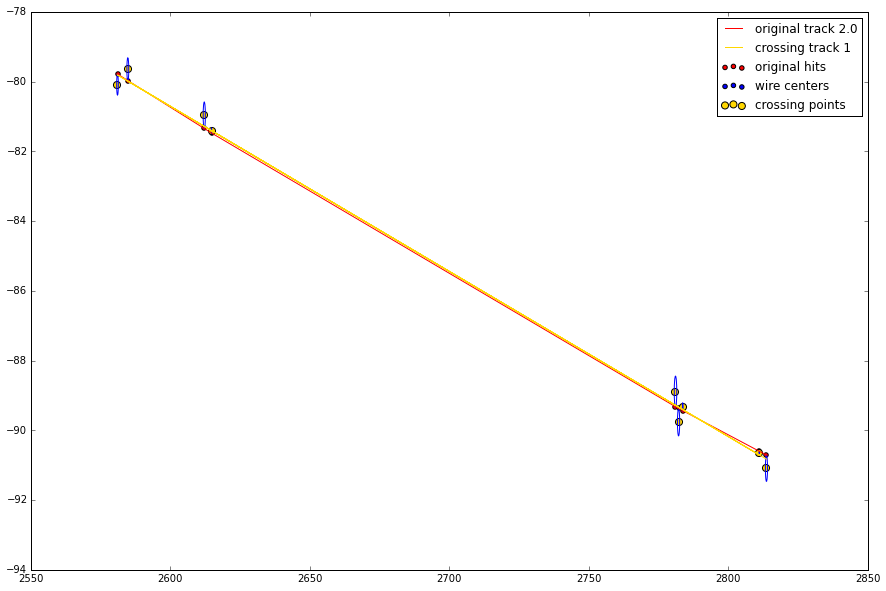

2029:


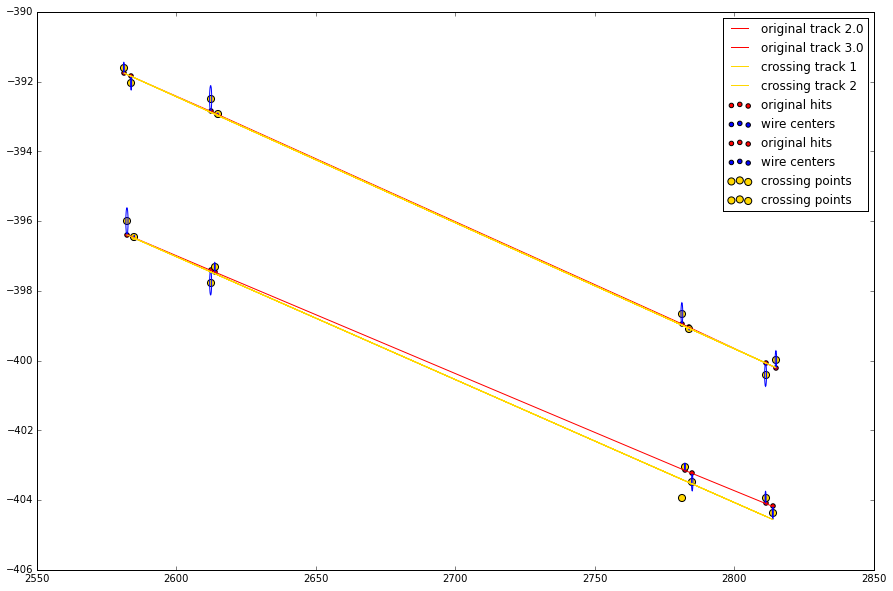

1533:


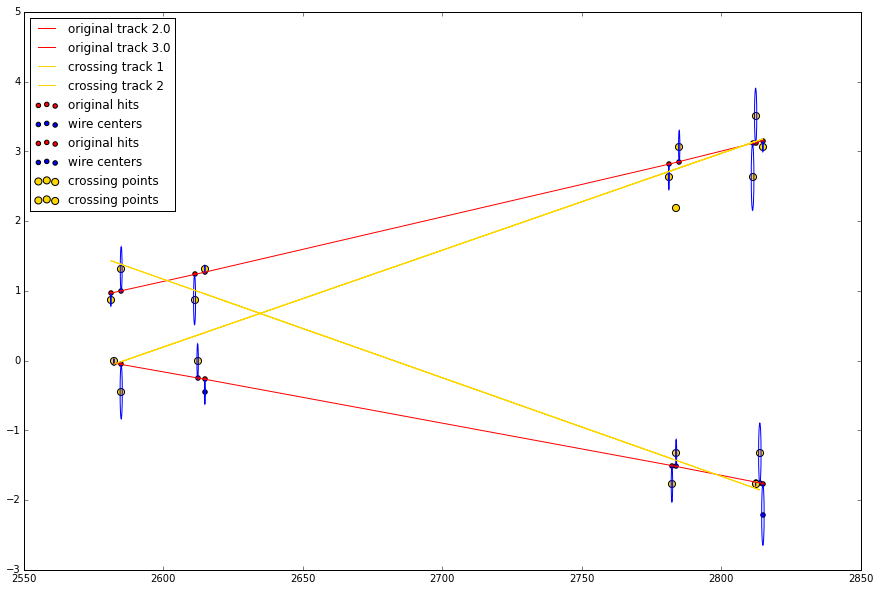

In [27]:
picture(bad_withoutClf_mlr, 1)

# With Classifier, mlr

In [28]:
bad_withClf_mlr

[1036, 27, 558, 84, 606, 143, 1722, 1756, 1848, 970, 2040, 2029, 1533]

1036:


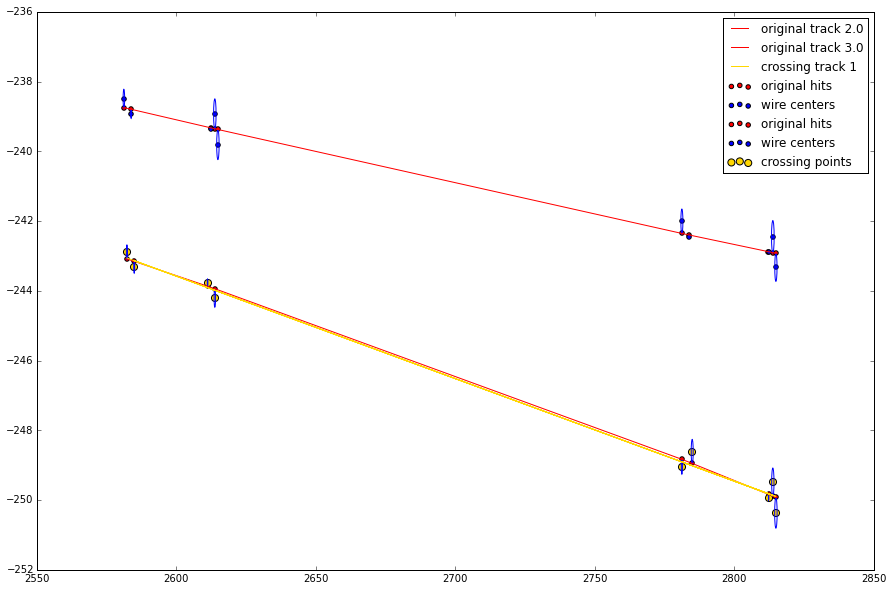

27:


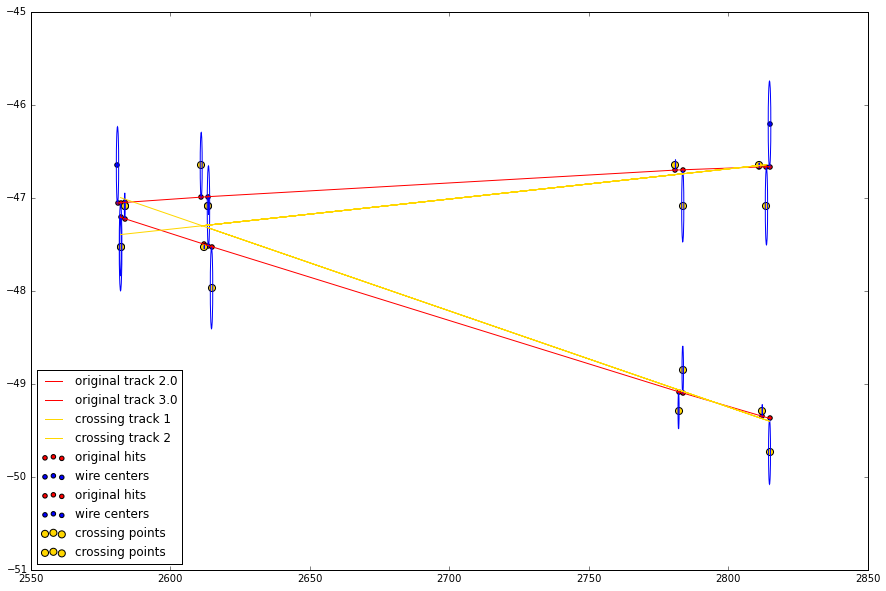

558:


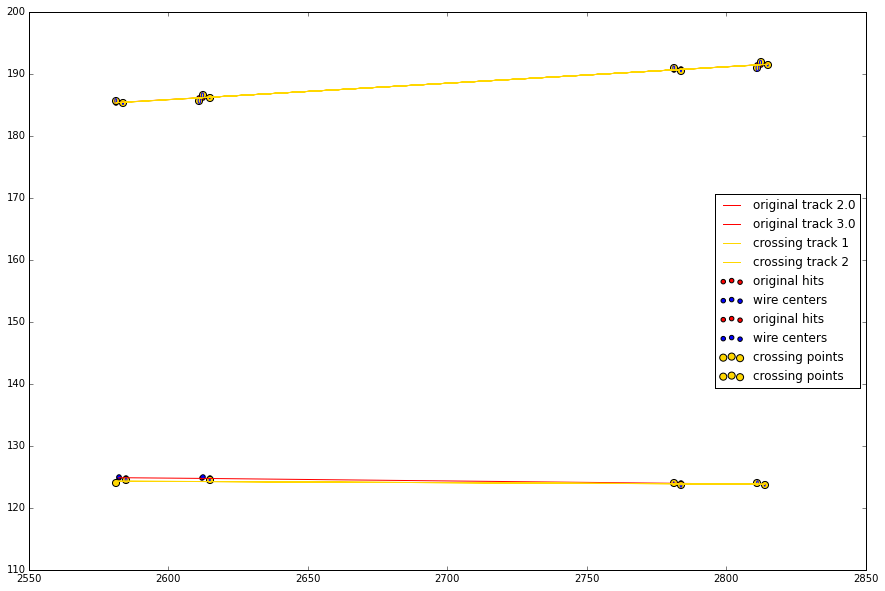

84:


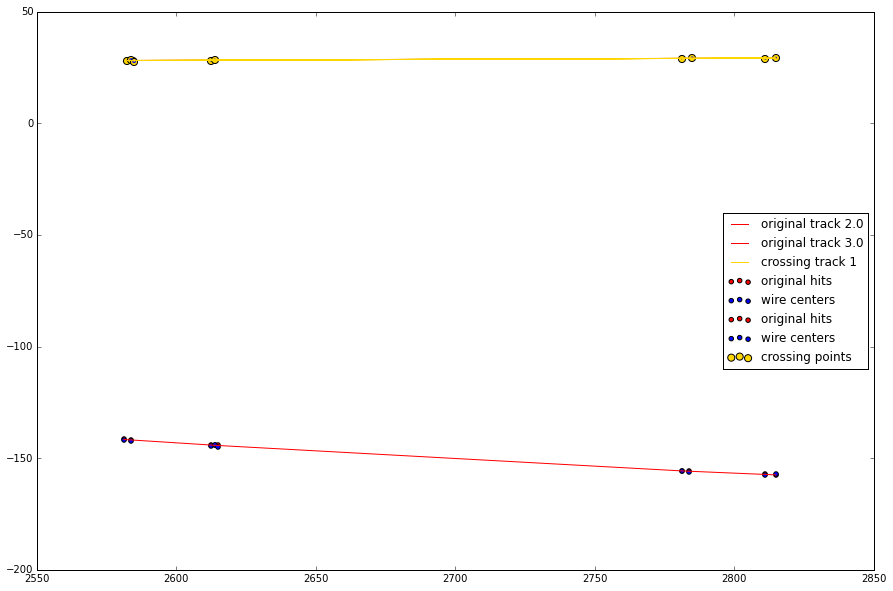

606:


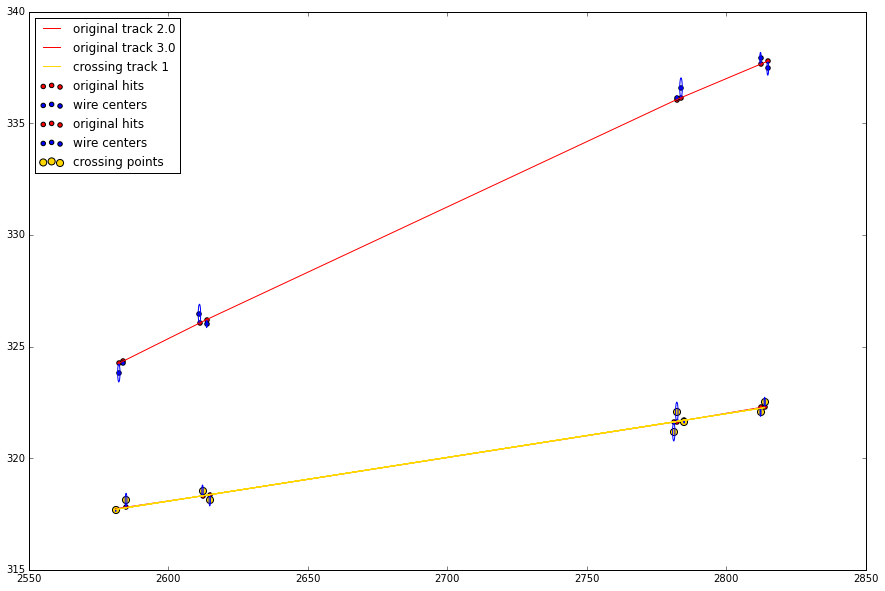

143:


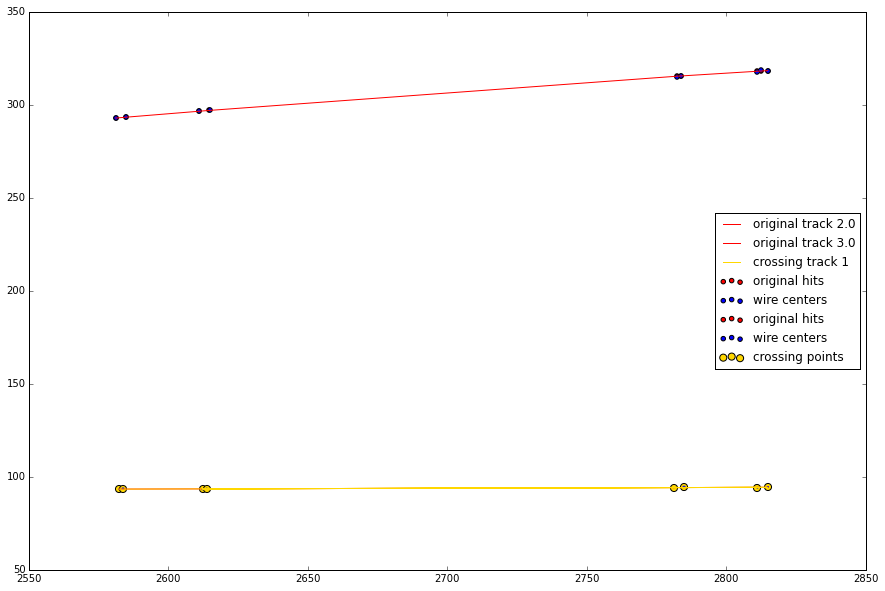

1722:


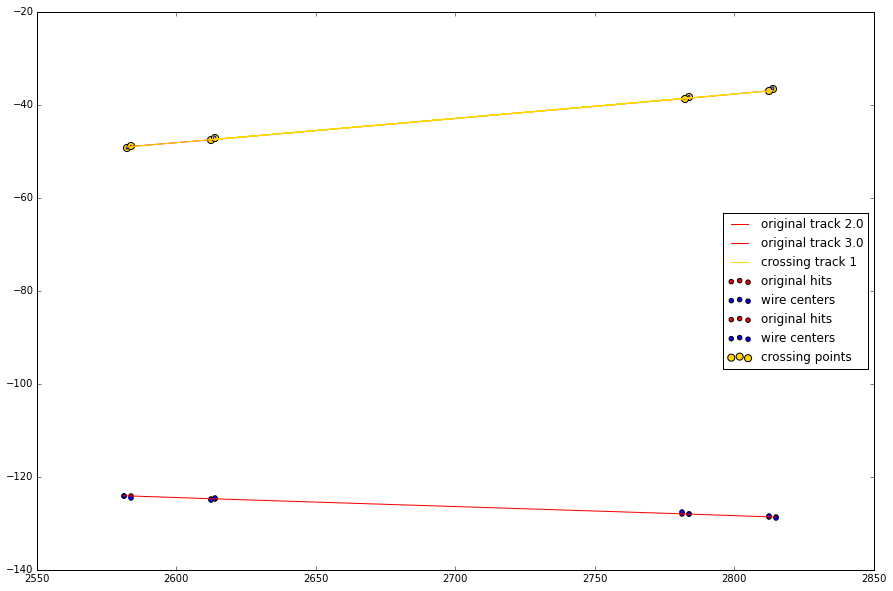

1756:


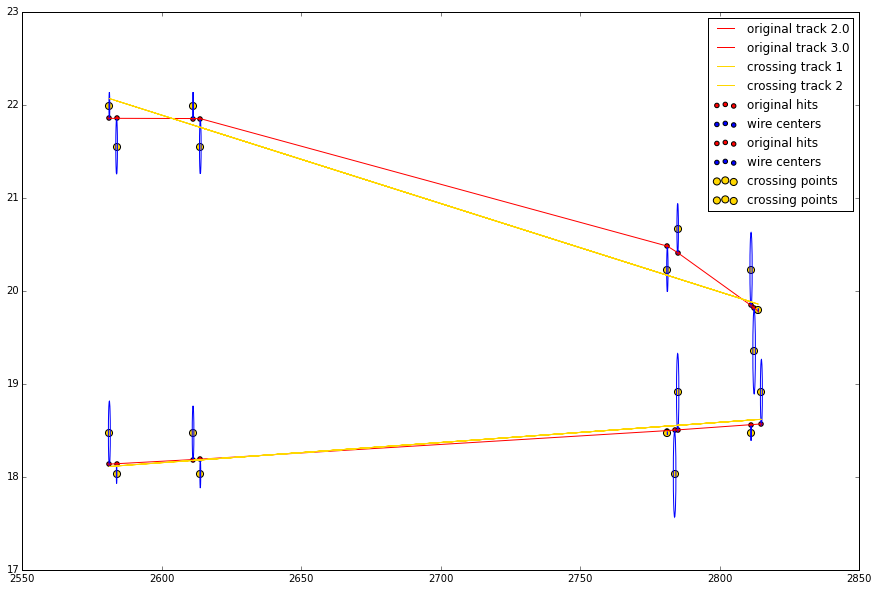

1848:


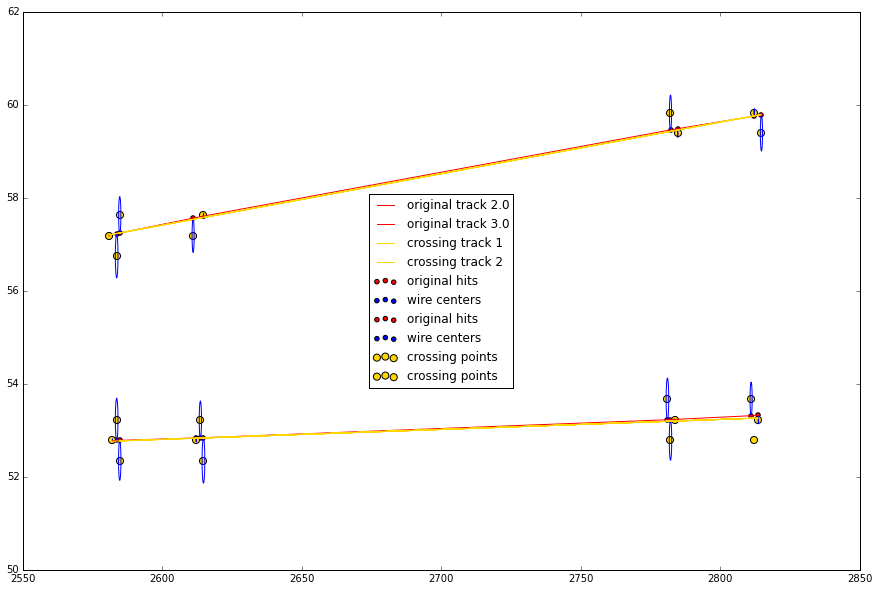

970:


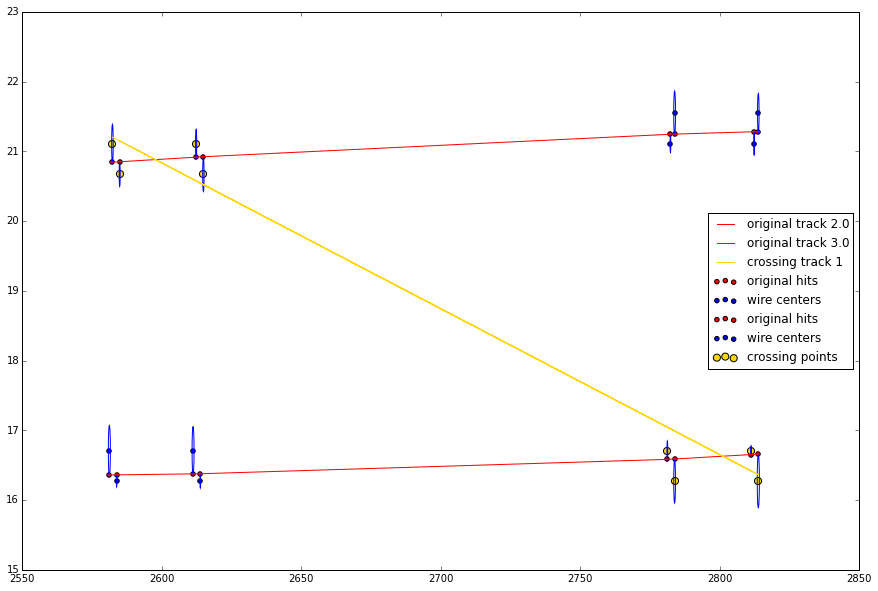

2040:


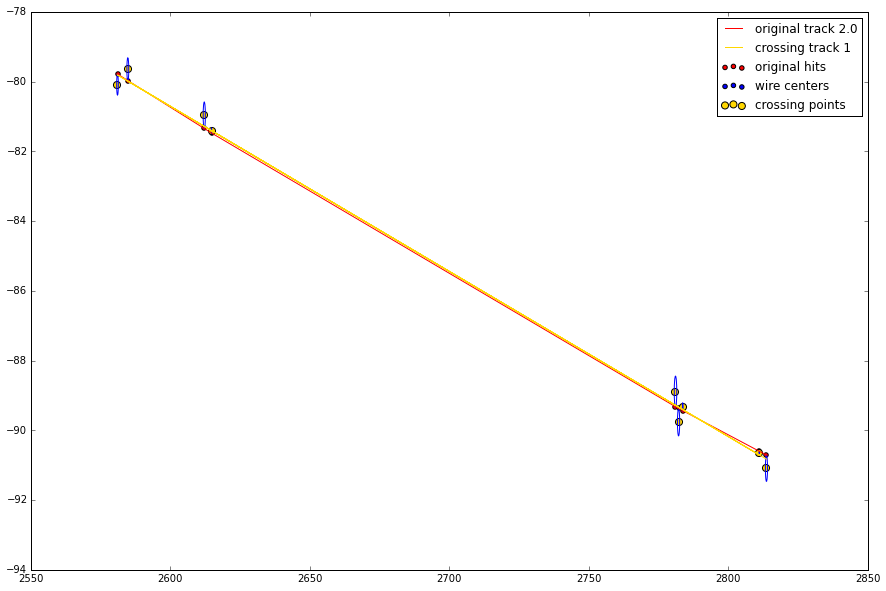

2029:


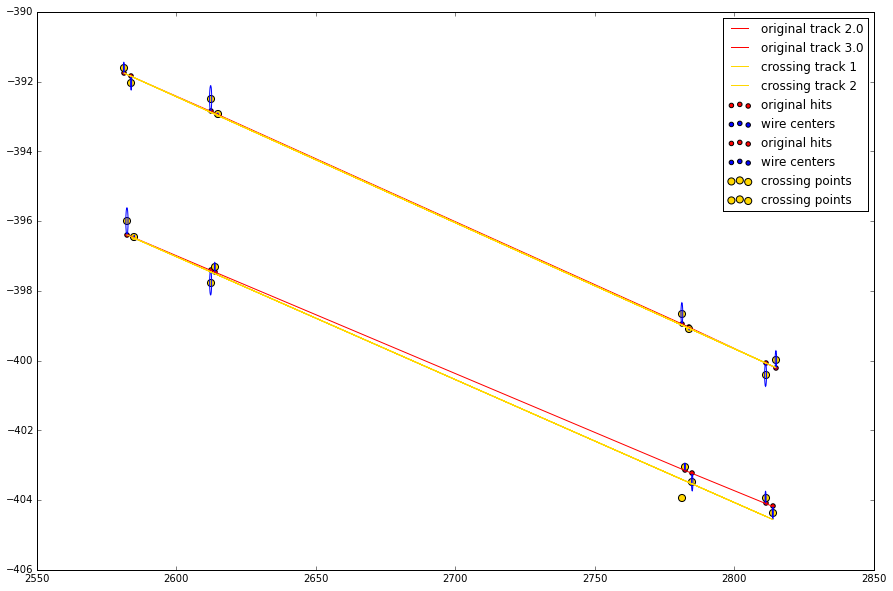

1533:


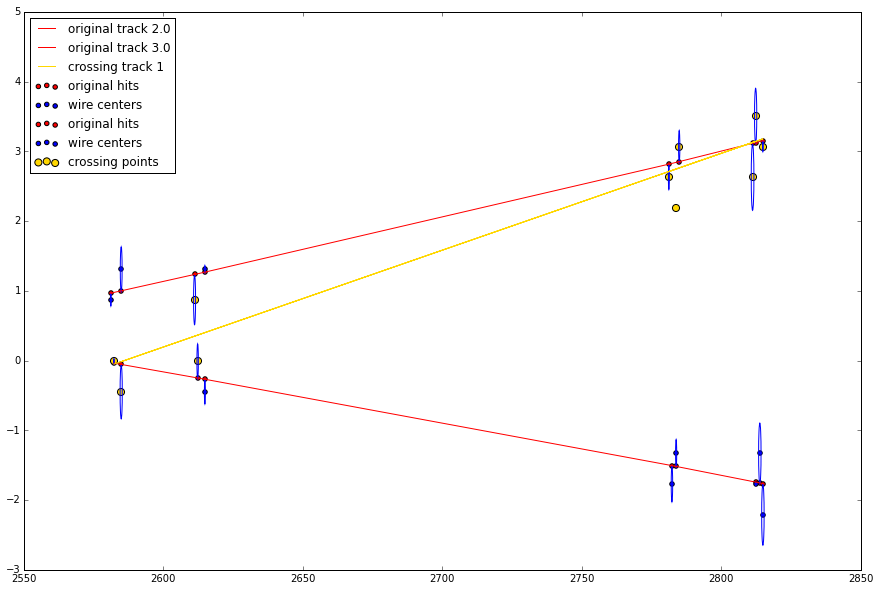

In [29]:
pictureClf(bad_withClf_mlr, 1, clf)